# Fama: 소형주, PBR, LSV: PER, PCR

한국 증시에서 시가총액이 작은 500개 소형주를 대상으로 PER, PBR, PCR 순위를 매긴다. 세 지표의 종합 순위가 높은 50 여 종목을 매수하고 1년 주기로 리밸런싱한다.

### 구동 환경 설정

In [1]:
from collections import OrderedDict
from jupyterthemes import jtplot
import matplotlib.pyplot as plt

plt.style.use('bmh')
jtplot.style(theme='monokai')
%matplotlib inline

import matplotlib.font_manager as fm
import matplotlib as mpl

font_path = "C:\\Windows\\Fonts\\malgun.ttf"
font_name = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
from workbench.const import CALENDAR, DEFAULT_SETTING
from workbench.ts_data_handler import TimeSeriesDataLoader
from workbench.fn_data_handler import FundamentalDataLoader, FinanceRatio
from workbench.filter import CapSizeFilter, RatioFilter
from workbench.order import Order
from workbench.evaluation import Evaluation, Performance

In [3]:
init_year = DEFAULT_SETTING.INIT_YEAR
enter_year = init_year + 1
time_window = DEFAULT_SETTING.TIME_WINDOW

## 시계열 데이터 불러오기

### 가격, 시가총액

In [4]:
ts_data_loader = TimeSeriesDataLoader()
# calendar = list(ts_data_loader.get_ts_data('trading_calendar'))
ts_benchmark = list(ts_data_loader.get_ts_data('kodex200'))
# ts_benchmark[0]

In [5]:
ts_price_years = list(ts_data_loader.get_ts_data('price'))
# len(ts_price_years)  # 2010-04-01 ~

In [6]:
ts_capsize_years = list(ts_data_loader.get_ts_data('capsize', first_year=init_year, reference_date=CALENDAR.OPENING_DATE))
# ts_capsize_years[0]  # 2009-01-02 ~

### 매년 시가총액 하위 500개 기업 (약 25%) 가격 데이터

In [7]:
filter_ = CapSizeFilter()
small_cap = list(filter_.get_small_capsize(ts_capsize_years, percentile=0.25))
ts_small_cap_price = list(filter_.get_small_cap_price(ts_price_years, small_cap))

## 재무 데이터 불러오기

### 당기순이익, 자산총계, 영업현금흐름

In [8]:
fn_data_loader = FundamentalDataLoader()
earning_years = OrderedDict(fn_data_loader.get_fn_data('earning', init_year=init_year, where='is'))
book_value_years = OrderedDict(fn_data_loader.get_fn_data('book_value', init_year=init_year, where='bs'))
cash_flow_years = OrderedDict(fn_data_loader.get_fn_data('cashflow', init_year=init_year, where='cf'))
# book_value_years[init_year]

### PER, PBR, PCR

In [9]:
per = OrderedDict(FinanceRatio().get_ratio(small_cap, earning_years))
pbr = OrderedDict(FinanceRatio().get_ratio(small_cap, book_value_years))
pcr = OrderedDict(FinanceRatio().get_ratio(small_cap, cash_flow_years))

In [10]:
per[init_year].describe()

count     358.000000
mean      -14.510893
std       261.113634
min     -3792.076996
25%        -6.496549
50%        -0.853253
75%        16.330790
max       801.176199
dtype: float64

In [11]:
per[init_year].sort_values()

A013780   -3792.076996
A032680   -2500.020654
A065940   -1163.130313
A002420    -500.643593
A044960    -290.462221
A003310    -226.588075
A033340    -190.096106
A035200    -156.278324
A071930    -155.591072
A030720    -135.514273
A088390    -128.343456
A037550    -119.814992
A066590    -116.542616
A086060    -112.041935
A008500    -103.005594
A008800     -97.530018
A038530     -80.921114
A037270     -78.163325
A033600     -69.837060
A024940     -69.168860
A000760     -57.755248
A004590     -57.425729
A080440     -54.165159
A078860     -54.064279
A018500     -52.060131
A003780     -51.473789
A013000     -48.638369
A039040     -48.385003
A058450     -48.110677
A067630     -46.496729
              ...     
A090150      48.587766
A048770      48.950721
A009780      49.441012
A071950      51.040387
A082660      51.357057
A079170      52.129961
A020400      57.329502
A045300      62.319395
A065440      62.691477
A052670      63.024164
A054170      63.120635
A083450      63.631748
A068930    

In [12]:
ratio_filter = RatioFilter()
per = OrderedDict(ratio_filter.get_filtered_ratio(per, 0.00))
pbr = OrderedDict(ratio_filter.get_filtered_ratio(pbr, 0.00))
pcr = OrderedDict(ratio_filter.get_filtered_ratio(pcr, 0.00))

In [13]:
per_ranking = OrderedDict(ratio_filter.get_candidate_by_pct_rank(per, cut_off=-1))
pbr_ranking = OrderedDict(ratio_filter.get_candidate_by_pct_rank(pbr, cut_off=-1))
pcr_ranking = OrderedDict(ratio_filter.get_candidate_by_pct_rank(pcr, cut_off=-1))

PER, PBR, PCR 구하고 blah blah

In [14]:
score_board = OrderedDict(ratio_filter.integrate_score(per_ranking, pbr_ranking, pcr_ranking))

In [15]:
candidates = OrderedDict(ratio_filter.get_candidate_by_score(score_board, cut_off=100))
candidates.keys()

odict_keys([2009, 2010, 2011, 2012, 2013])

In [16]:
order = Order()
buy_list = OrderedDict(order.get_buylist(ts_small_cap_price, candidates, 50))
sell_list = OrderedDict(order.get_selllist(ts_small_cap_price, buy_list))
# buy_list[enter_year]

## Evaluation

In [17]:
ts_portf_val = Evaluation.get_ts_portf_val(ts_price_years, buy_list, "Fama+LSV")
# ts_portf_val
print(f"진입 자본: {int(ts_portf_val[0])}")

진입 자본: 11806176


In [18]:
benchmark_buy = OrderedDict(ts_data_loader.get_benchmark(ts_benchmark, ts_portf_val))
benchmark_buy[enter_year]

price  volume
KODEX 200  19733.18097       1

In [19]:
ts_benchmark_val = Evaluation.get_ts_portf_val(ts_benchmark, benchmark_buy)
# ts_benchmark_val

In [20]:
scaled_portf_val, scaled_benchmark_val = \
Evaluation.get_scaled_val(ts_portf_val), Evaluation.get_scaled_val(ts_benchmark_val)

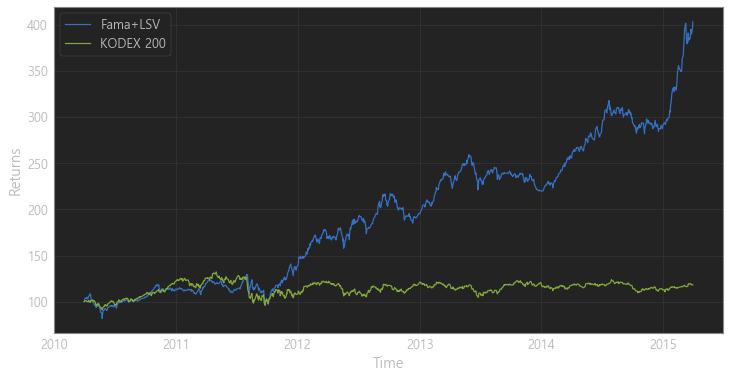

In [21]:
performance = Performance(scaled_portf_val, scaled_benchmark_val)
plt.rcParams["figure.figsize"] = (12,6)
performance.get_returns_plots()

### Compound Annaul Growth Rate: 연복리 수익률

In [22]:
performance.get_cagr()

Fama+LSV CAGR: 32.18 %
KODEX 200 CAGR: 3.44 %


### 매년 수익률

In [23]:
performance.get_annual_returns()

           2010   2011   2012  2013   2014
Fama+LSV  19.75  42.41  38.27  8.41  57.85
            2010  2011  2012  2013  2014
KODEX 200  25.61 -4.11  -1.3 -0.99  0.61


### 최대낙폭 Maximum Drawdown (%)

In [24]:
mdd = performance.get_mdd(ts_portf_val).popitem(last=False)  # 포트폴리오
print(f"MDD: {round(mdd[0], 2)} %")
print(f"고점: {int(ts_portf_val[mdd[1][0]])}, {mdd[1][0].strftime('%Y-%m-%d')}, 저점: {int(ts_portf_val[mdd[1][1]])}, {mdd[1][1].strftime('%Y-%m-%d')}")

MDD: 25.7 %
고점: 15308775, 2011-08-02, 저점: 11374639, 2011-09-26


In [25]:
mdd = performance.get_mdd(ts_benchmark_val).popitem(last=False)  # 벤치마크
print(f"MDD: {round(mdd[0], 2)} %")
print(f"고점: {int(ts_benchmark_val[mdd[1][0]])}, {mdd[1][0].strftime('%Y-%m-%d')}, 저점: {int(ts_benchmark_val[mdd[1][1]])}, {mdd[1][1].strftime('%Y-%m-%d')}")

MDD: 27.42 %
고점: 26107, 2011-05-02, 저점: 18949, 2011-09-26


### 무위험 수익률 proxy: CD91

In [26]:
daily_rf = ts_data_loader.get_ts_daily_risk_free_rate(scaled_portf_val)

### 위험 조정 수익률 Sharpe ratio

In [27]:
performance.get_sharpe_ratio(daily_rf)  # 포트폴리오

Portfolio: Fama+LSV
Sharpe Ratio: 1.4280510057595552

Portfolio: KODEX 200
Sharpe Ratio: 0.17106829911759164



### 정보 비율 Information ratio (benchmark: KODEX 200)

In [28]:
performance.get_information_ratio(ts_portf_val, ts_benchmark_val)  # 벤치마크 대비 포트폴리오

Portfolio: Fama+LSV
Information Ratio: 1.545790735012041



### 매일 승률 Hit ratio

In [29]:
performance.get_hit_ratio()  # 포트폴리오

Portfolio: Fama+LSV
Win days: 57.51 %
Lose days: 41.68 %

Portfolio: KODEX 200
Win days: 50.97 %
Lose days: 46.77 %



### 포트폴리오 개별 종목 추이

Year: 2010, Profit: 29, Loss: 21, Sum: 50


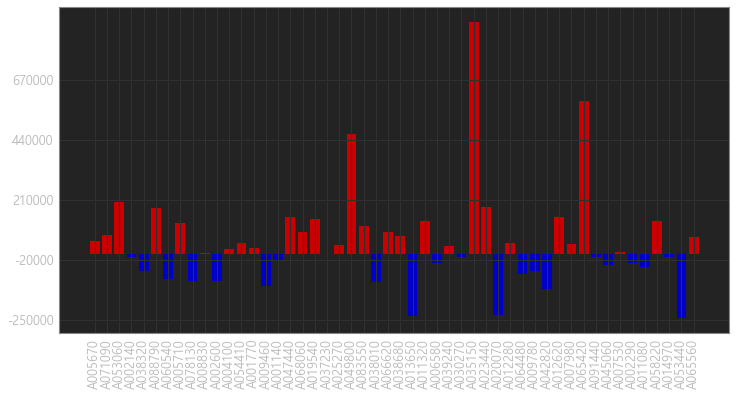

Year: 2011, Profit: 35, Loss: 15, Sum: 50


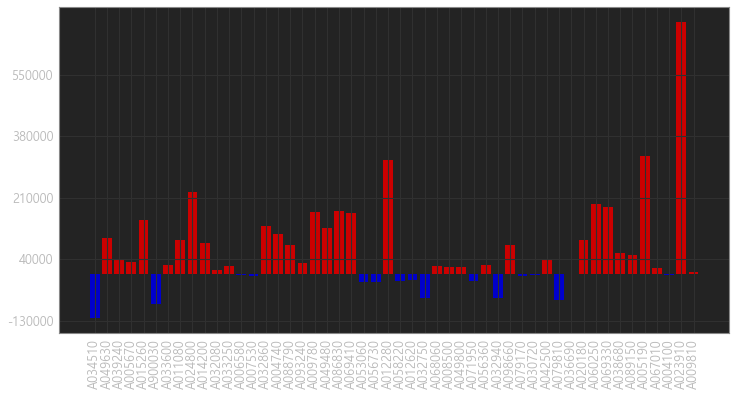

Year: 2012, Profit: 37, Loss: 13, Sum: 50


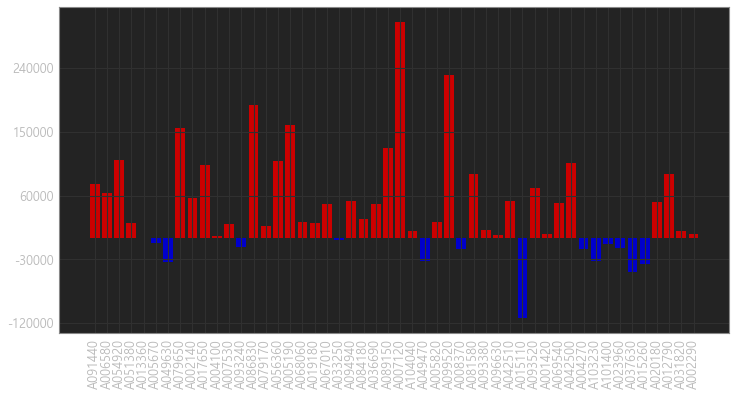

Year: 2013, Profit: 25, Loss: 24, Sum: 49


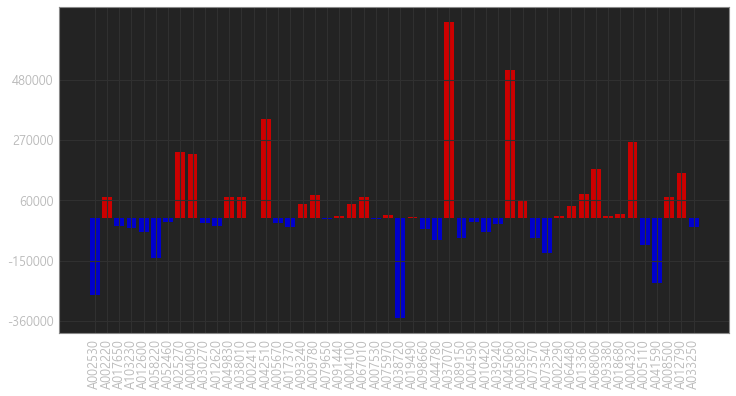

Year: 2014, Profit: 41, Loss: 9, Sum: 50


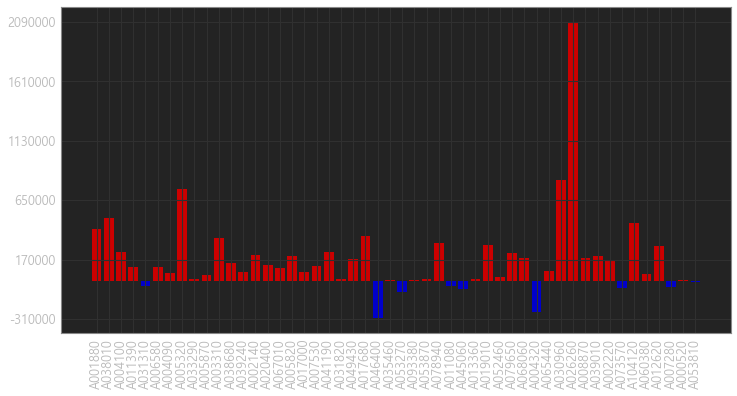

In [30]:
result = OrderedDict(performance.get_pnl(buy_list, sell_list))

In [31]:
result[enter_year]

profit     loss
0   A005670  A002140
1   A071090  A038320
2   A053060  A060540
3   A088790  A078130
4   A005710  A002600
5   A008830  A009460
6   A004100  A001140
7   A054410  A038010
8   A001770  A013650
9   A047440  A006580
10  A068060  A030270
11  A019540  A020070
12  A037230  A064480
13  A025270  A009780
14  A049800  A042820
15  A083550  A091440
16  A066620  A045060
17  A038680  A002290
18  A011320  A011080
19  A039240  A014970
20  A035150  A053440
21  A023440      NaN
22  A012280      NaN
23  A012620      NaN
24  A007980      NaN
25  A065420      NaN
26  A007530      NaN
27  A058220      NaN
28  A065560      NaN

2010


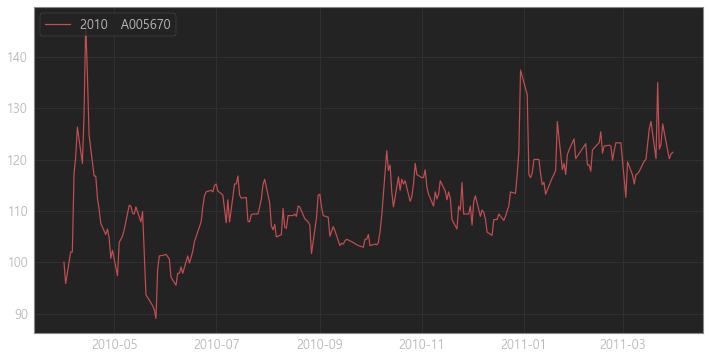

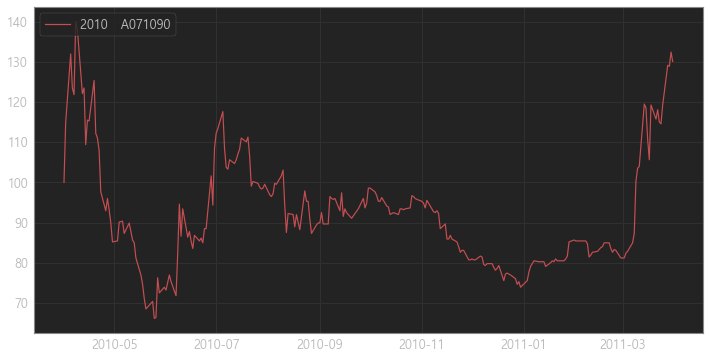

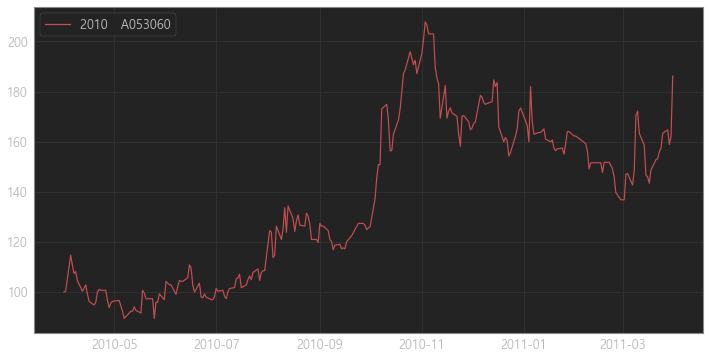

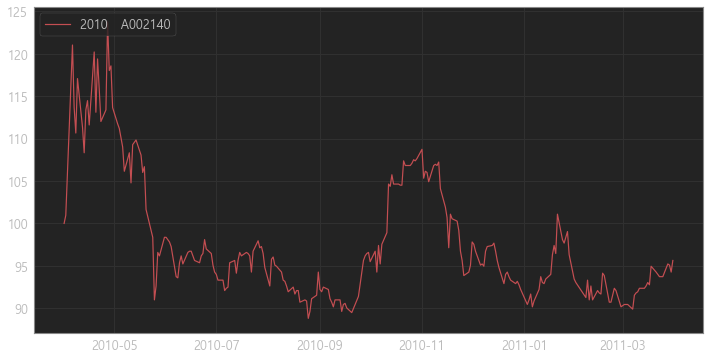

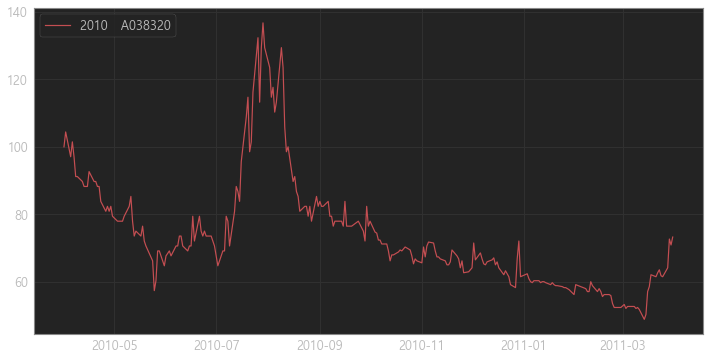

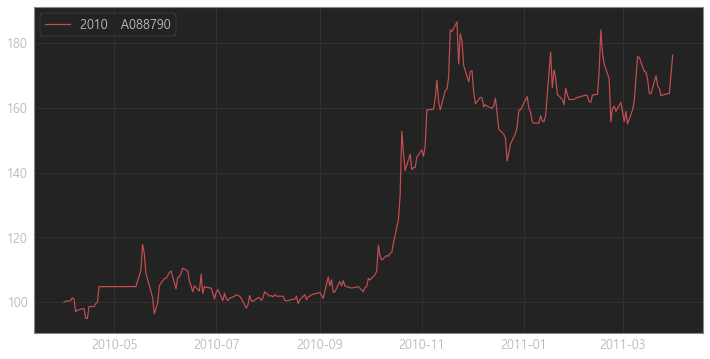

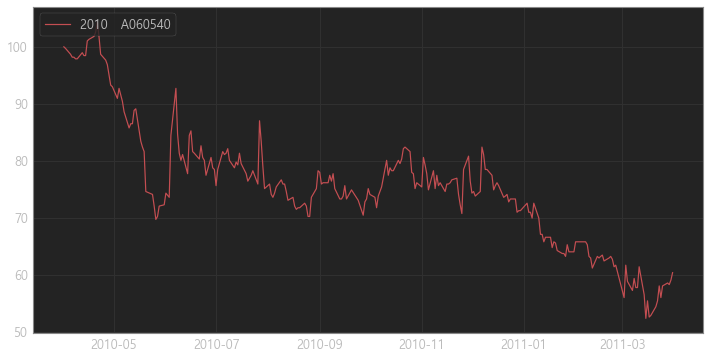

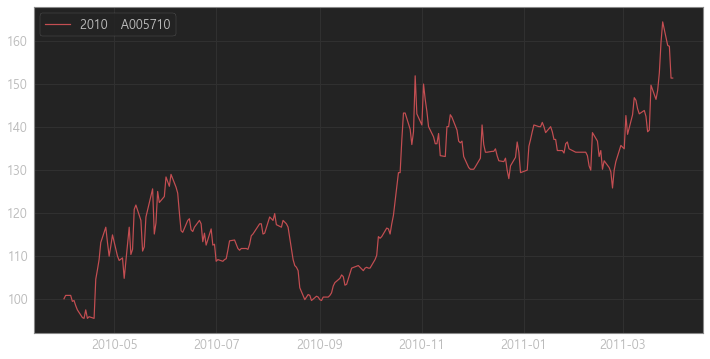

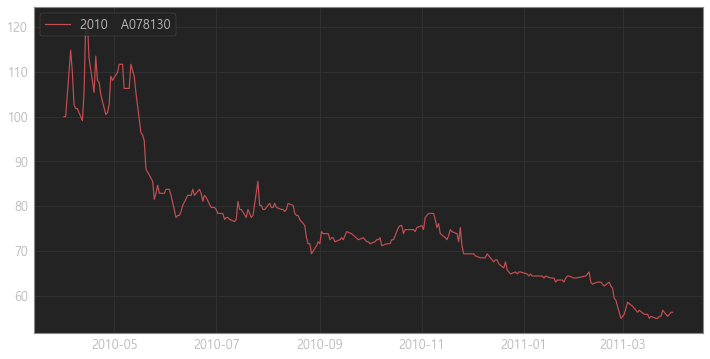

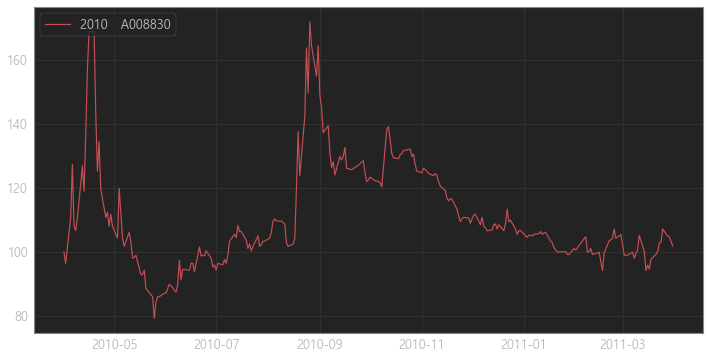

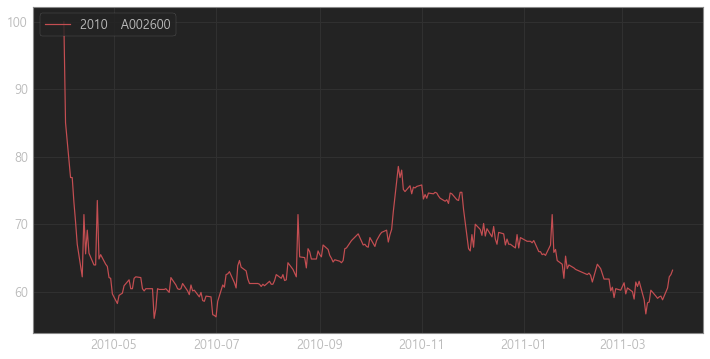

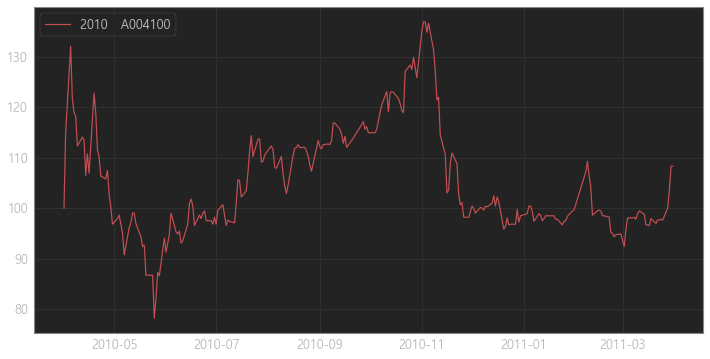

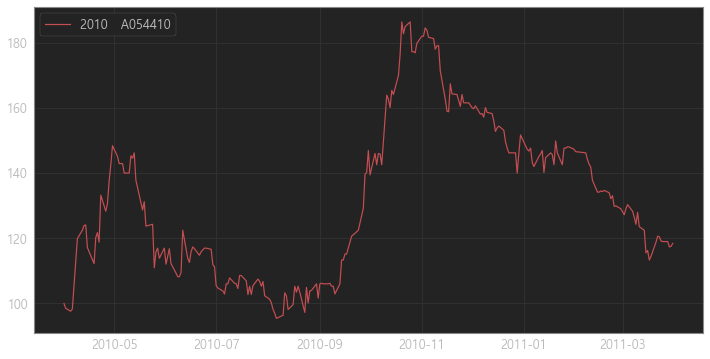

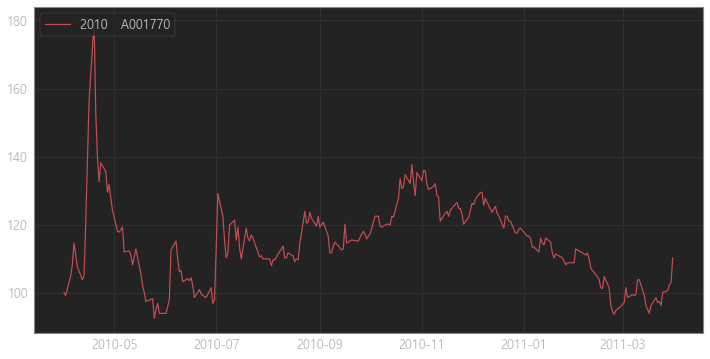

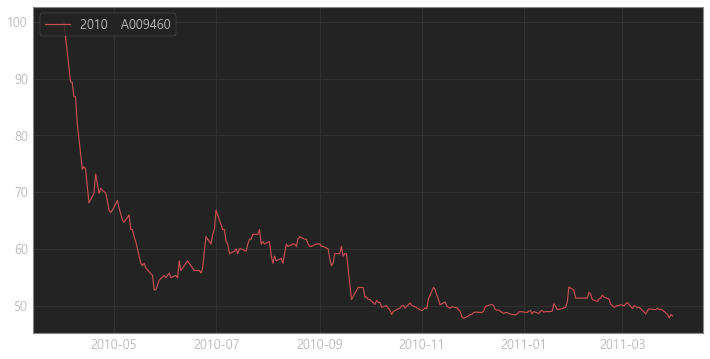

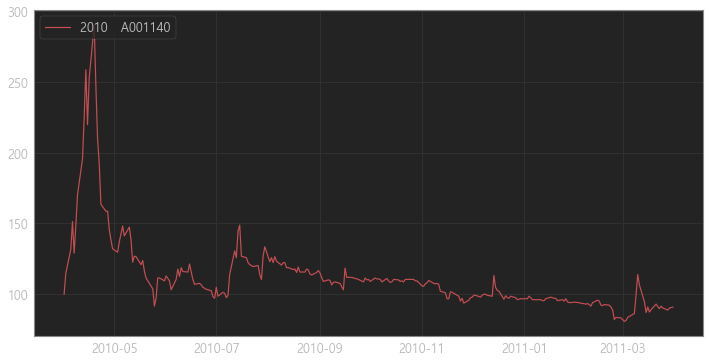

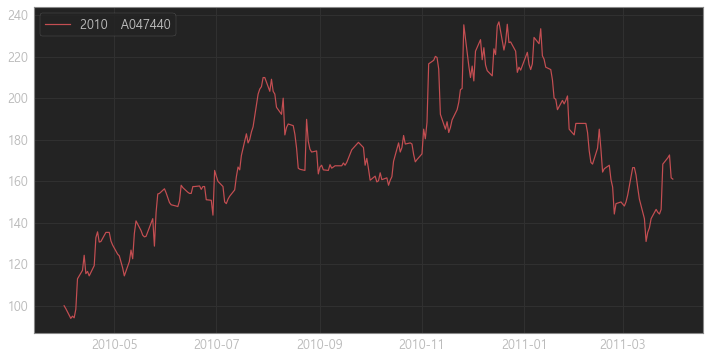

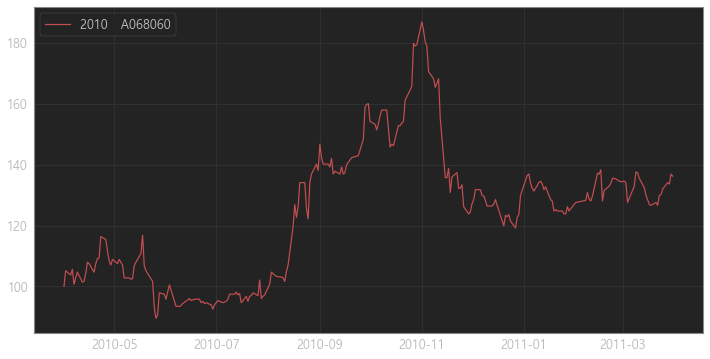

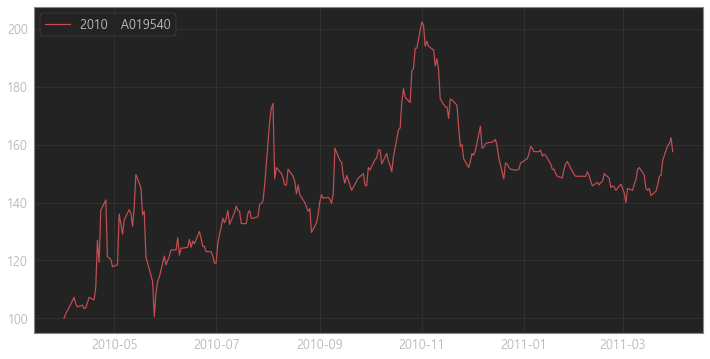

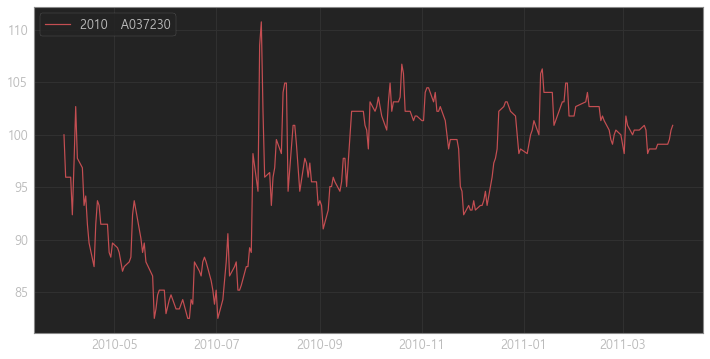

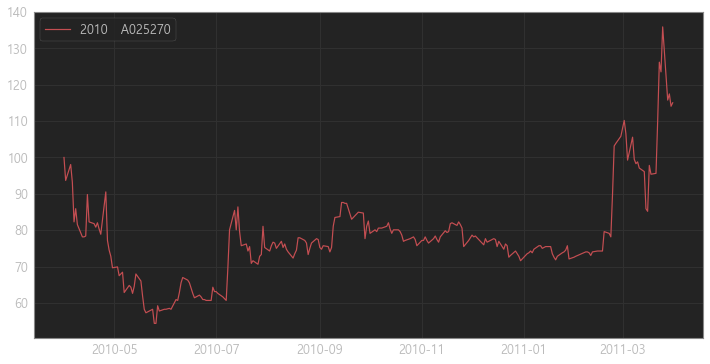

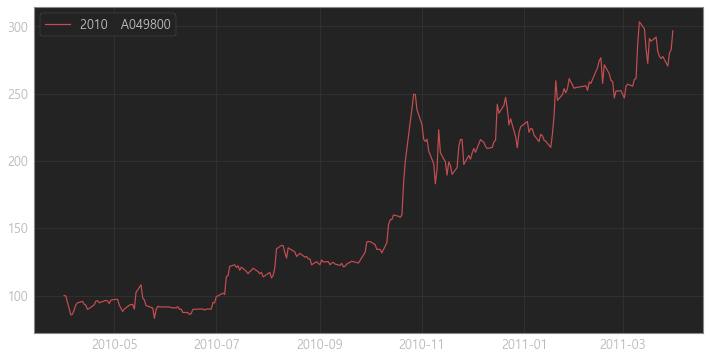

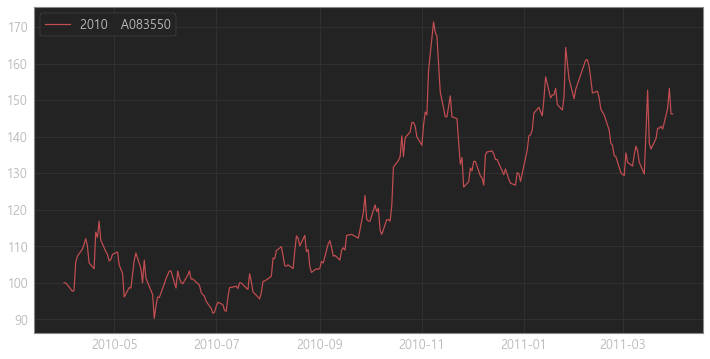

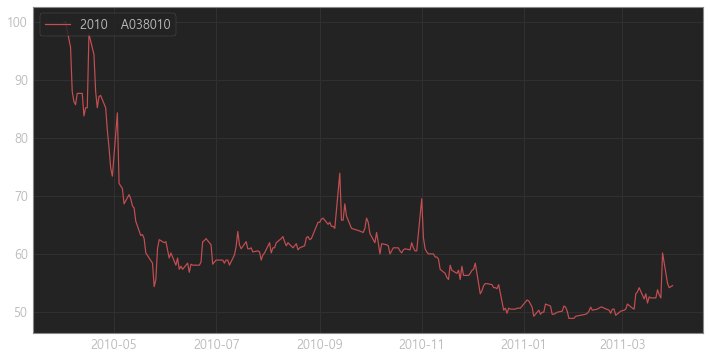

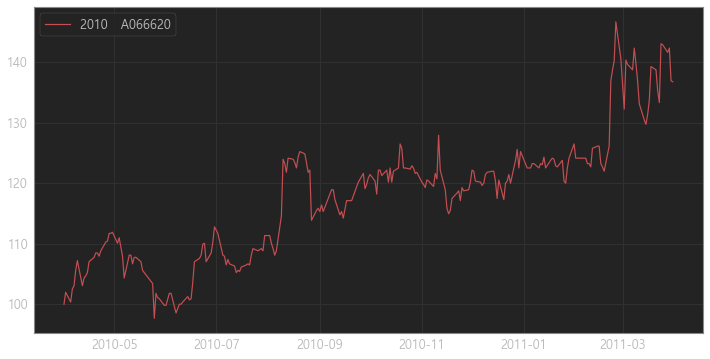

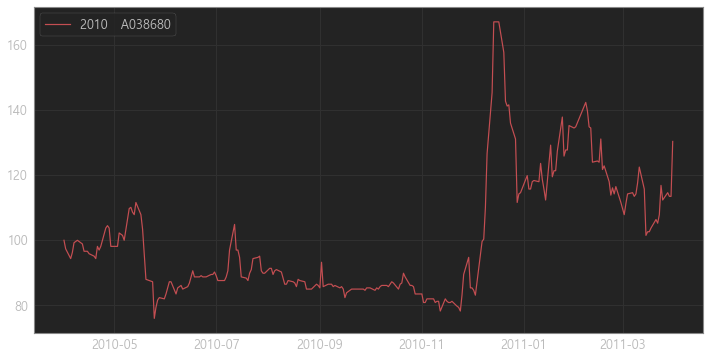

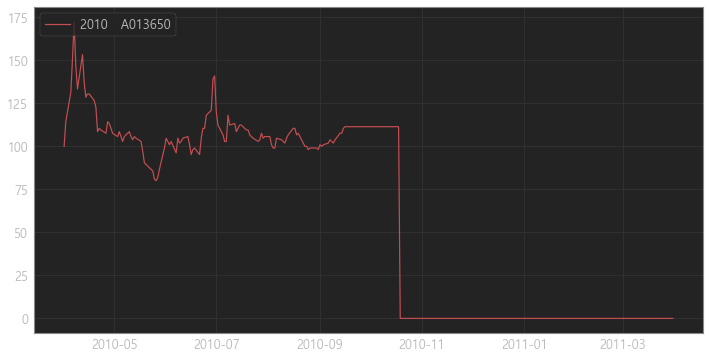

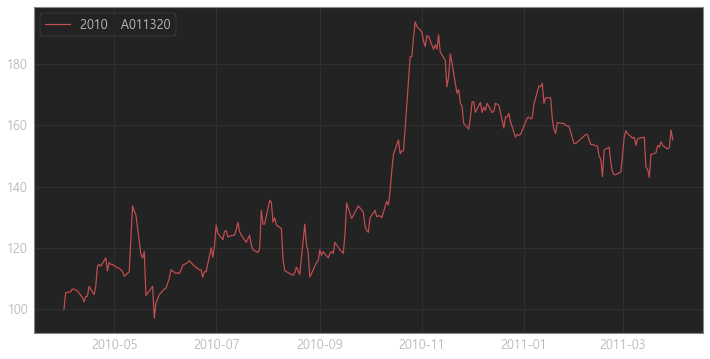

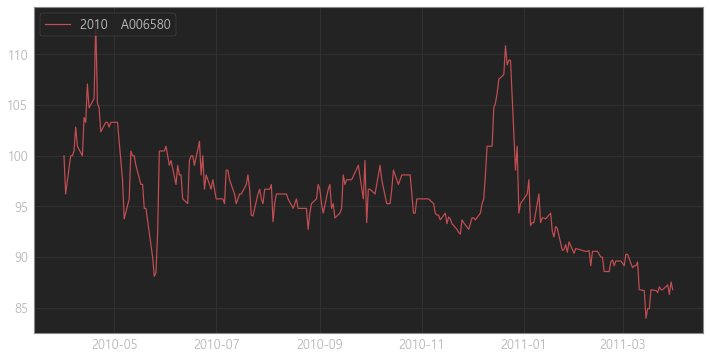

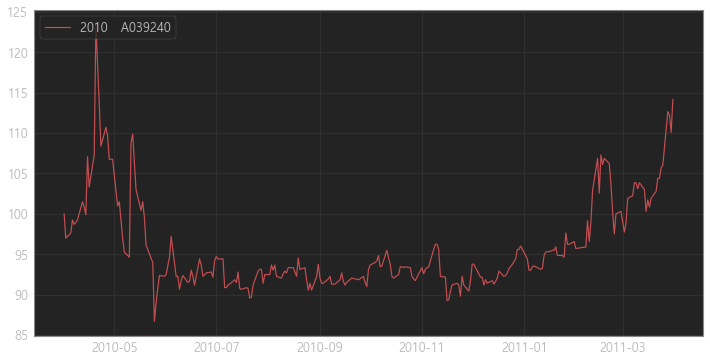

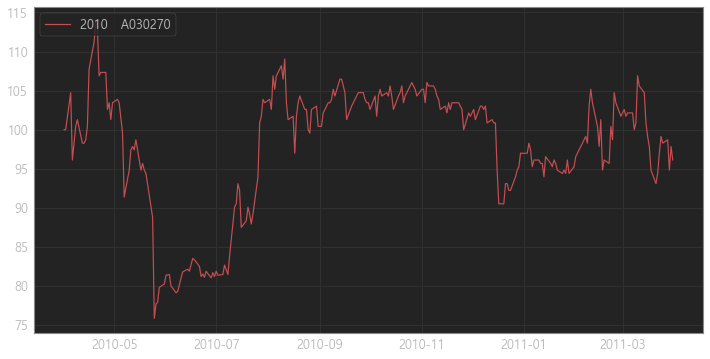

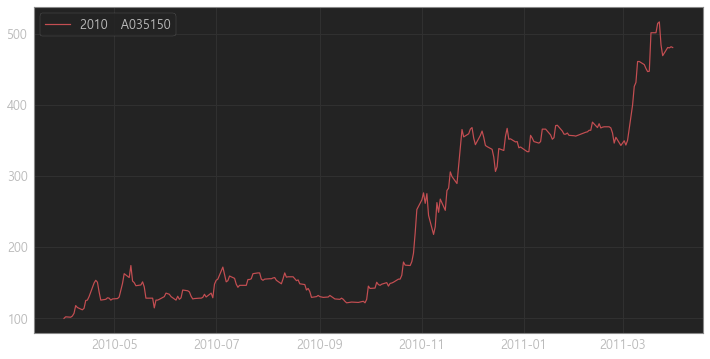

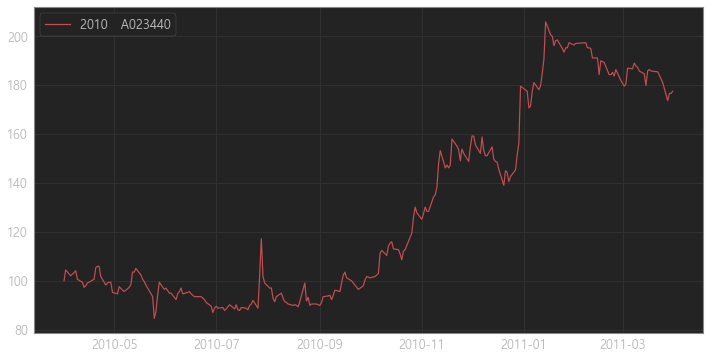

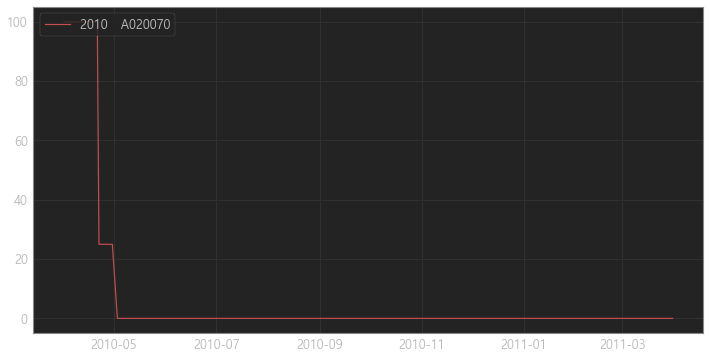

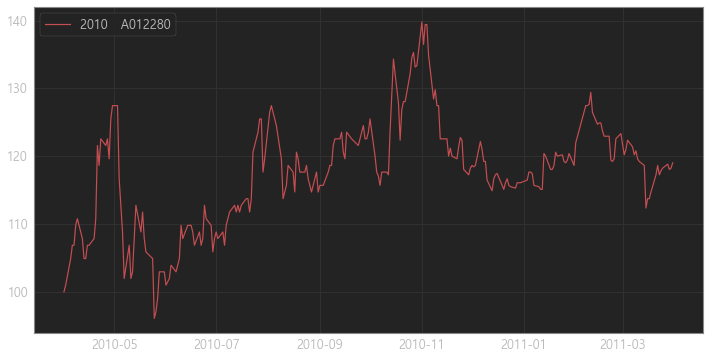

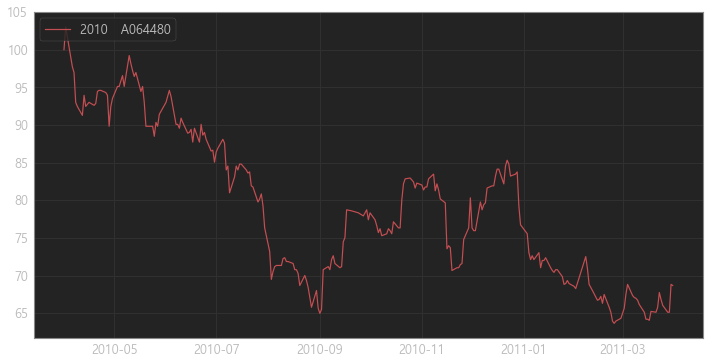

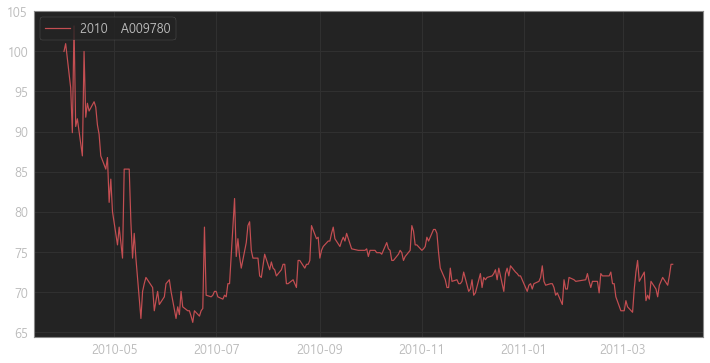

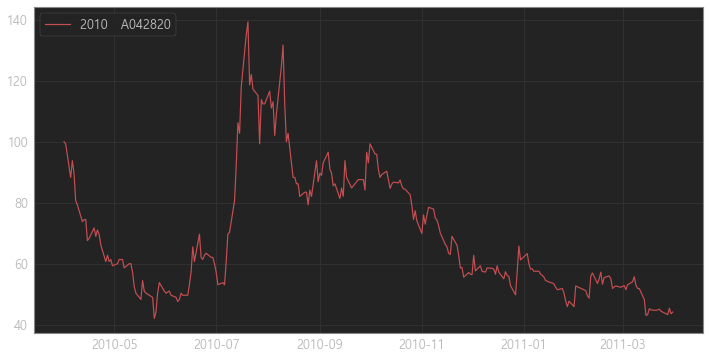

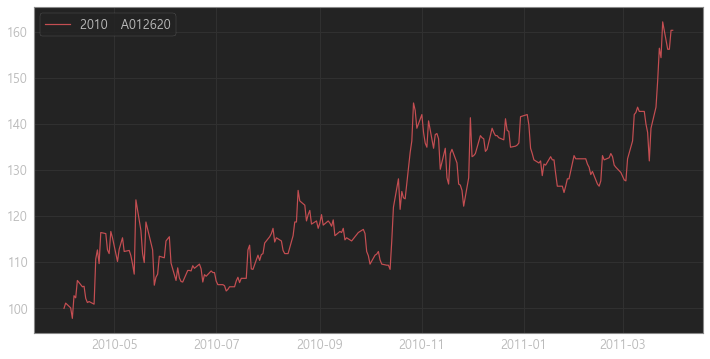

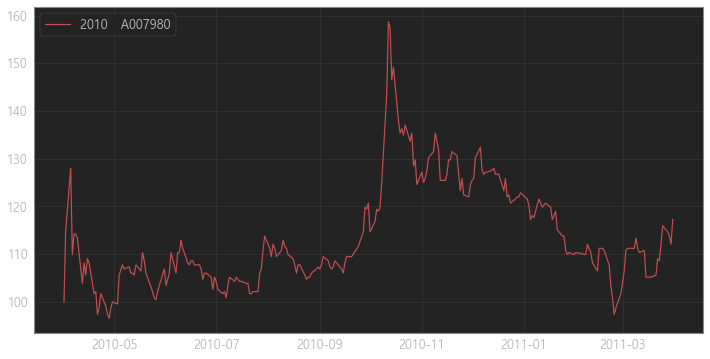

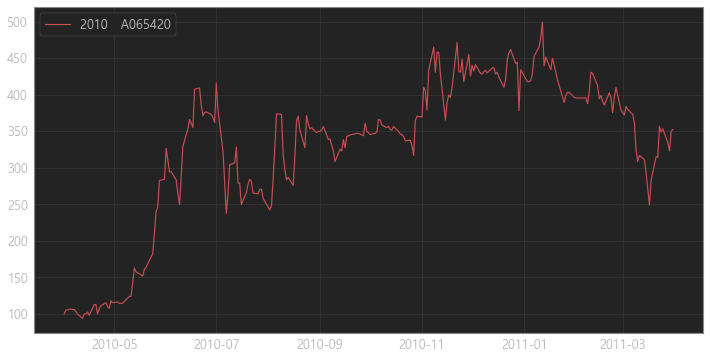

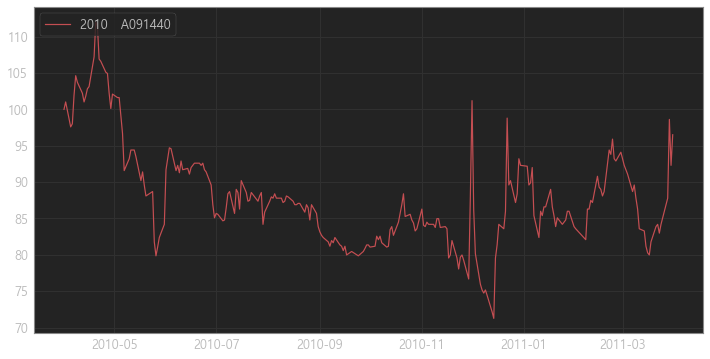

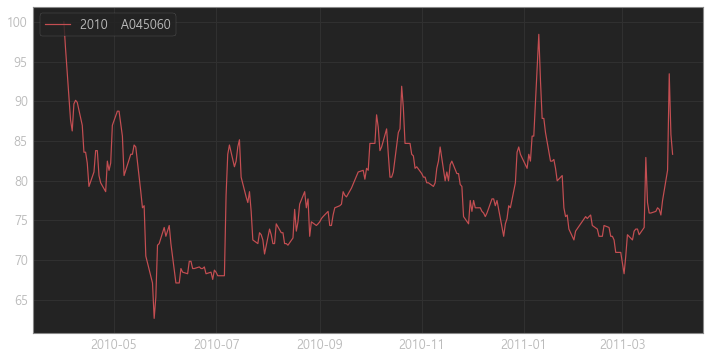

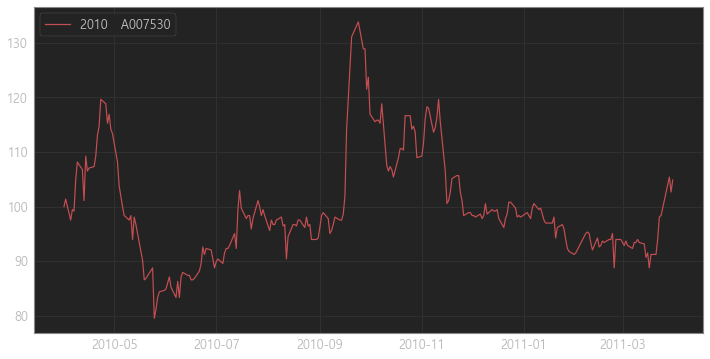

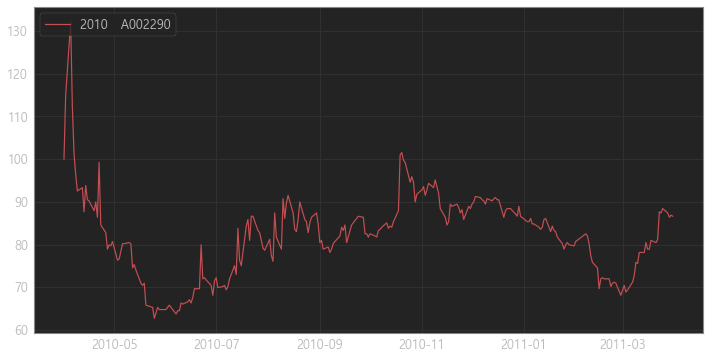

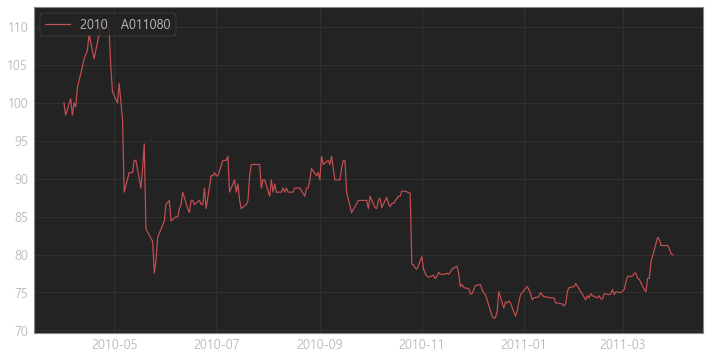

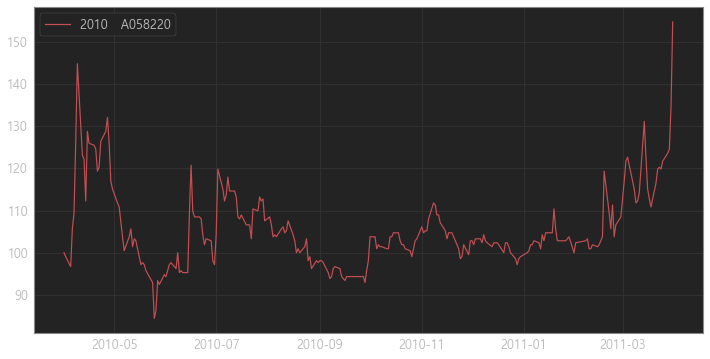

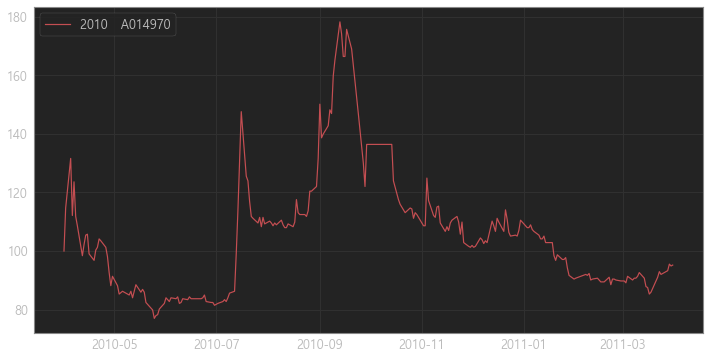

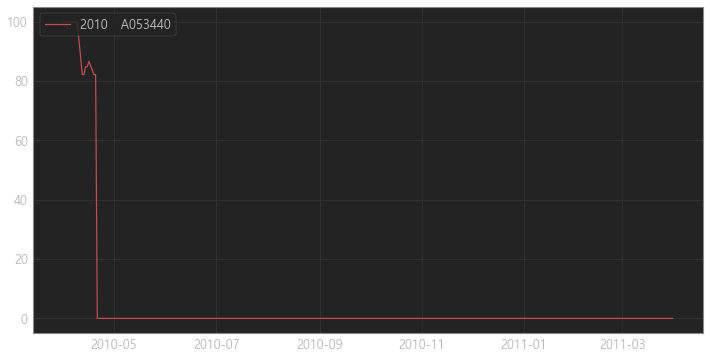

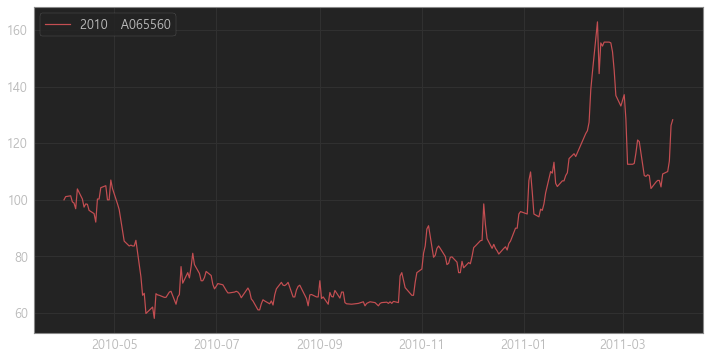

2011


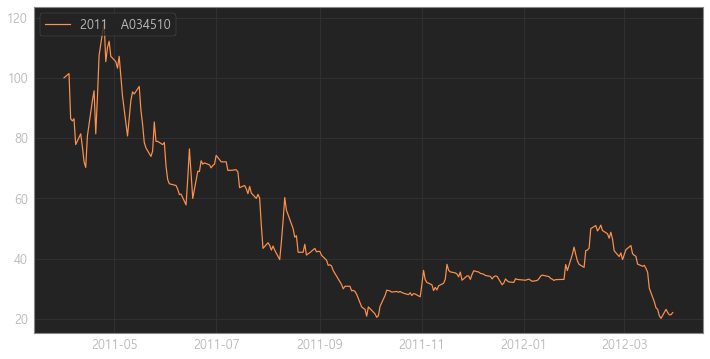

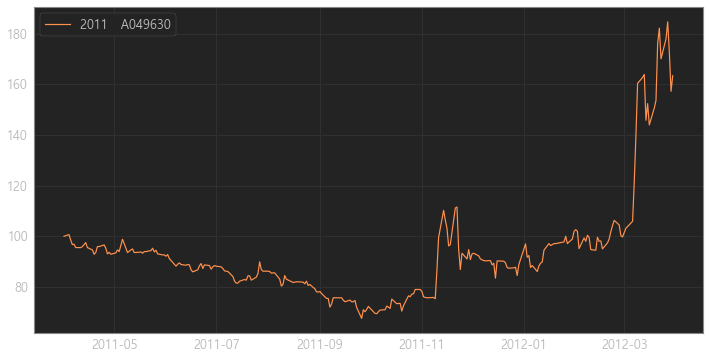

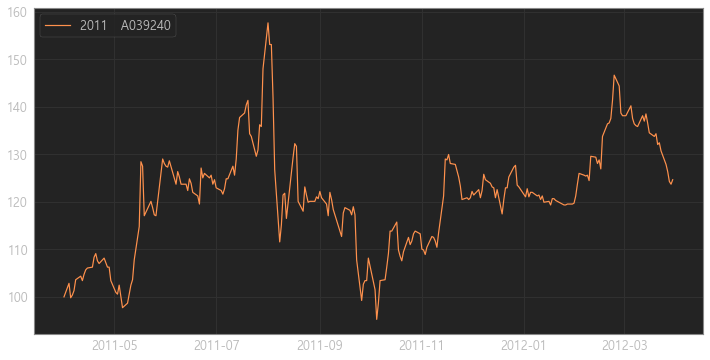

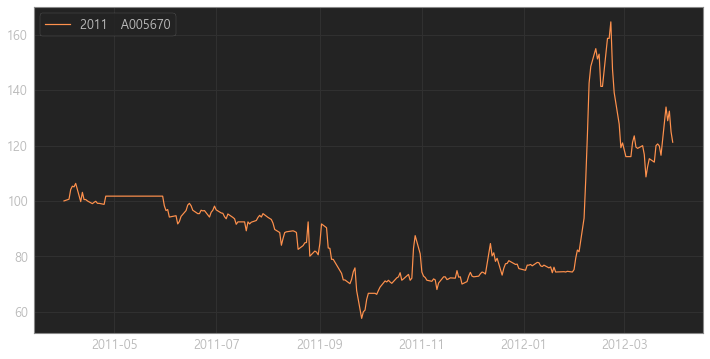

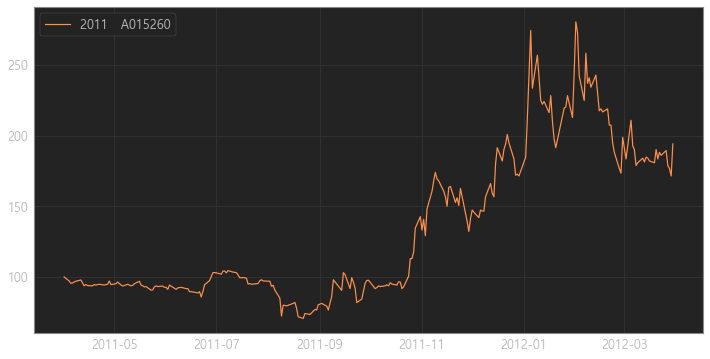

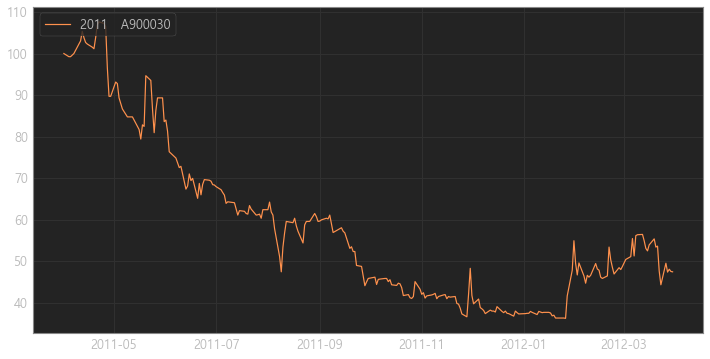

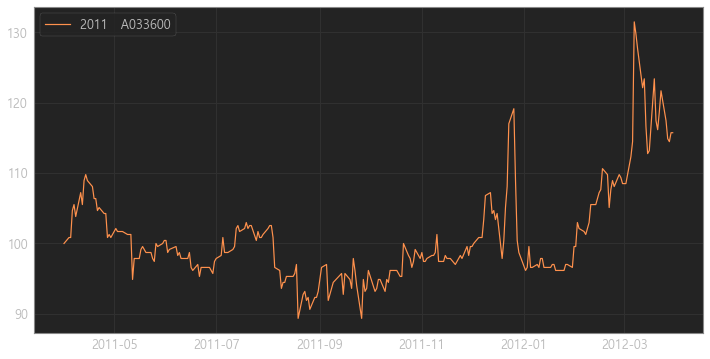

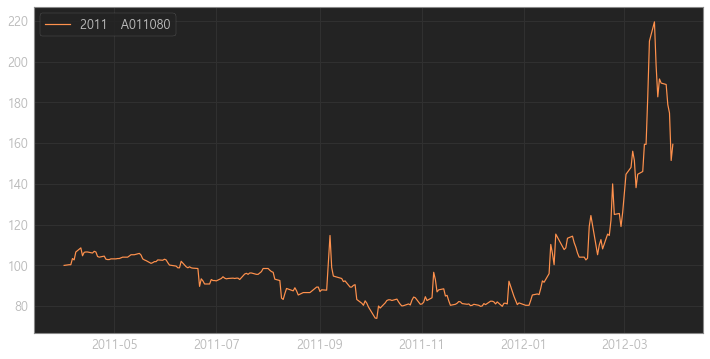

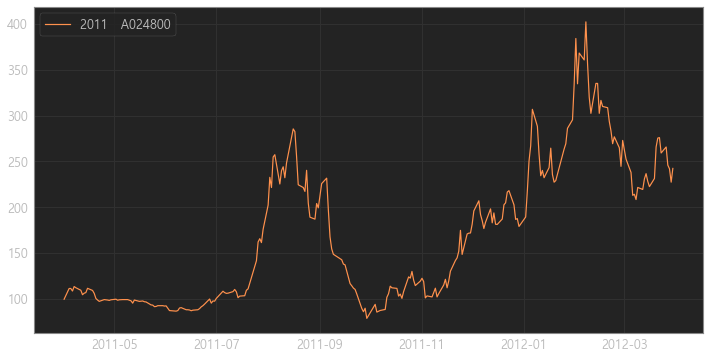

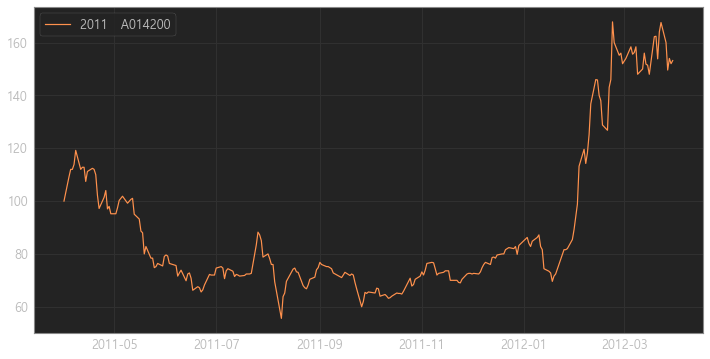

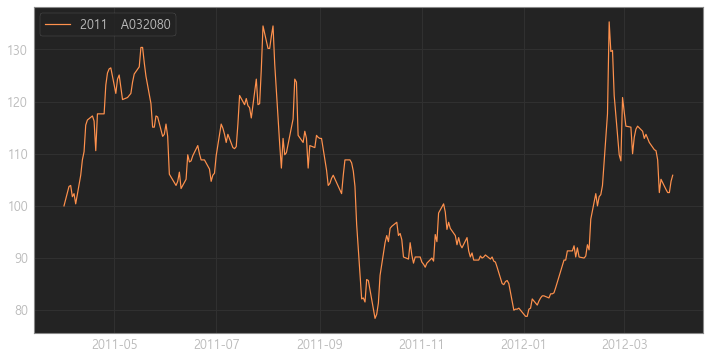

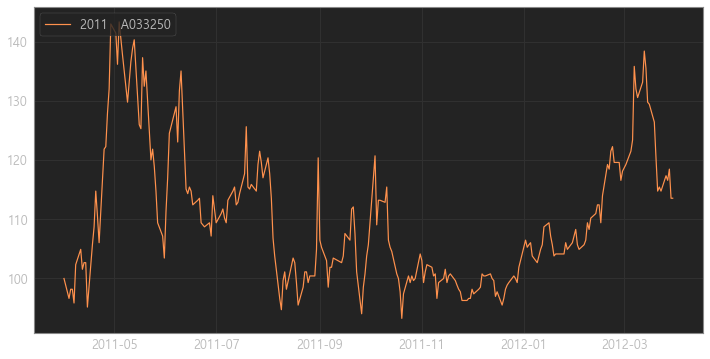

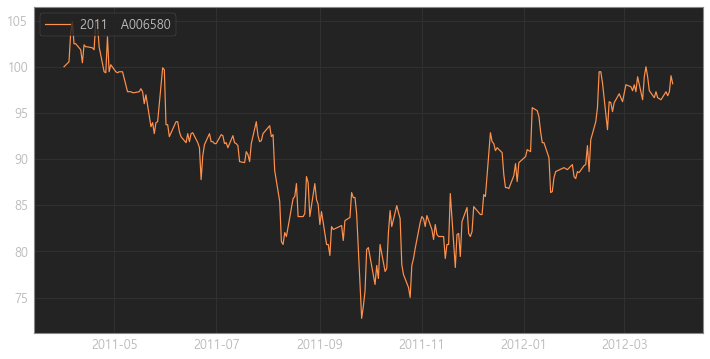

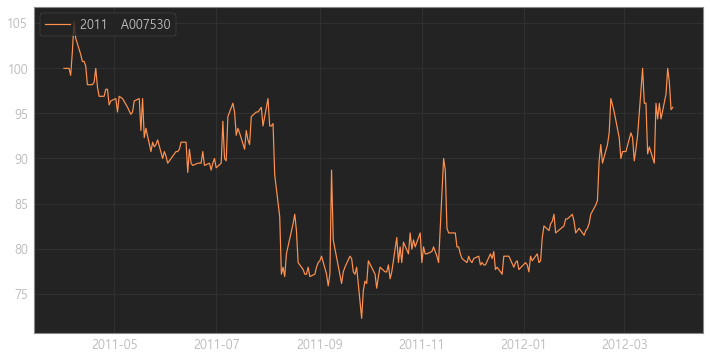

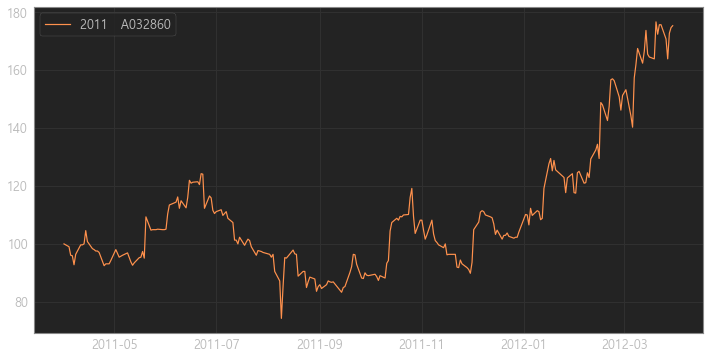

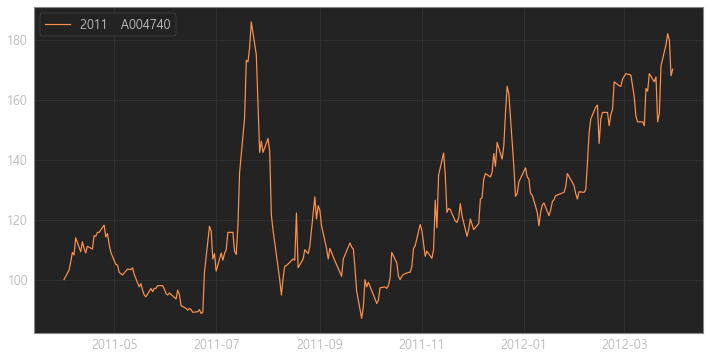

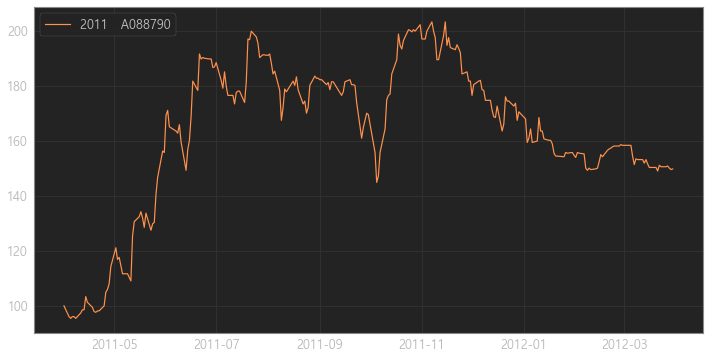

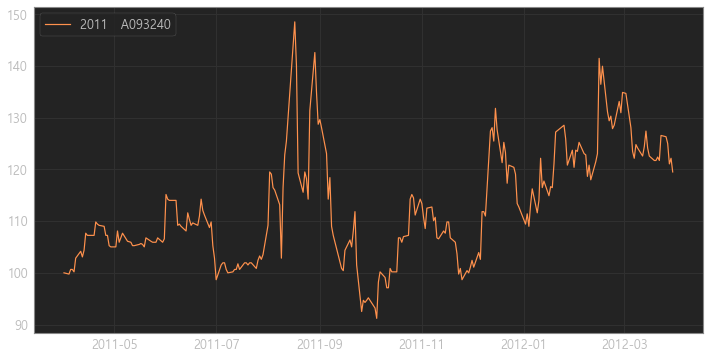

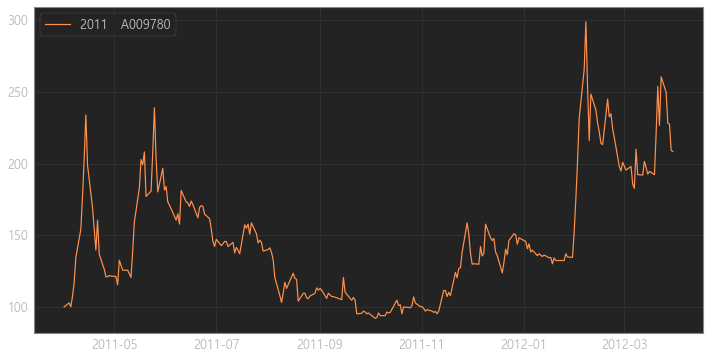

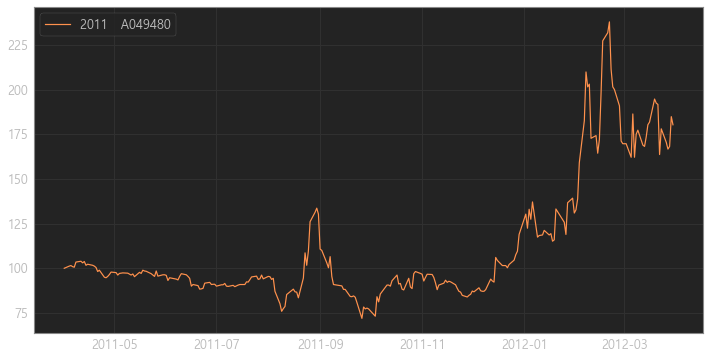

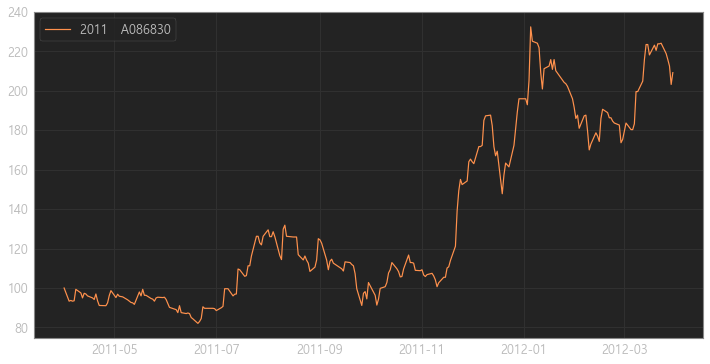

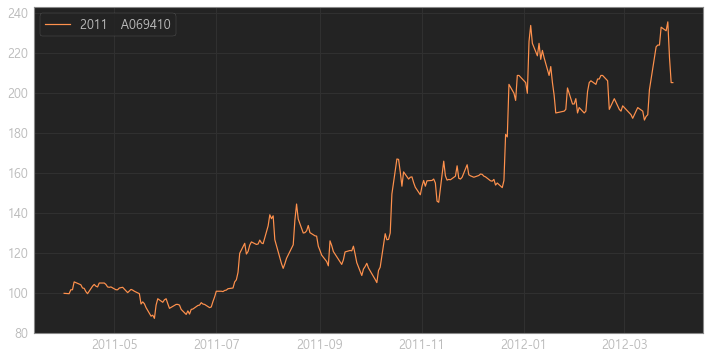

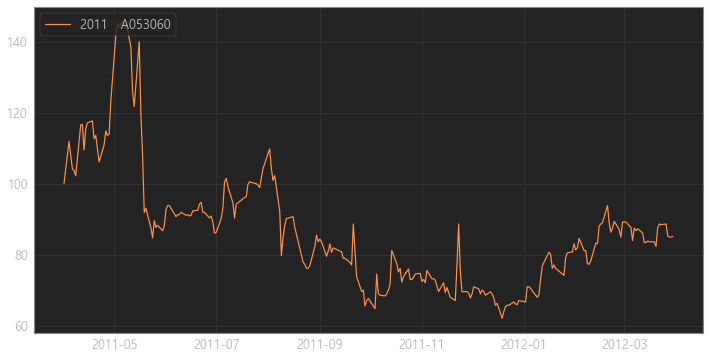

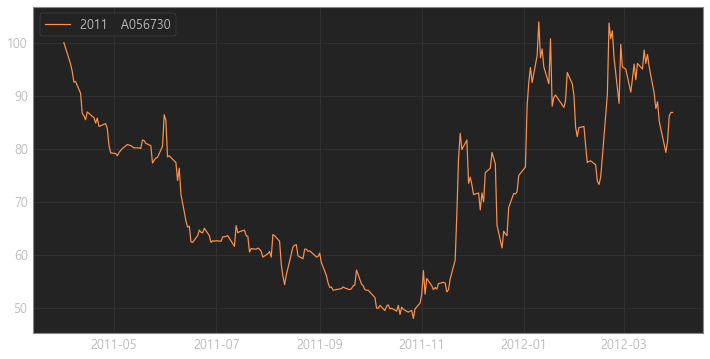

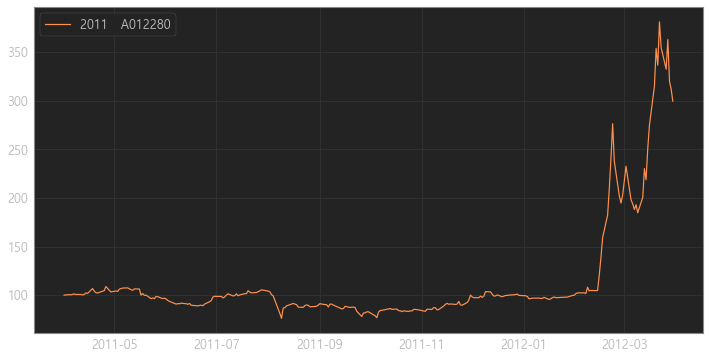

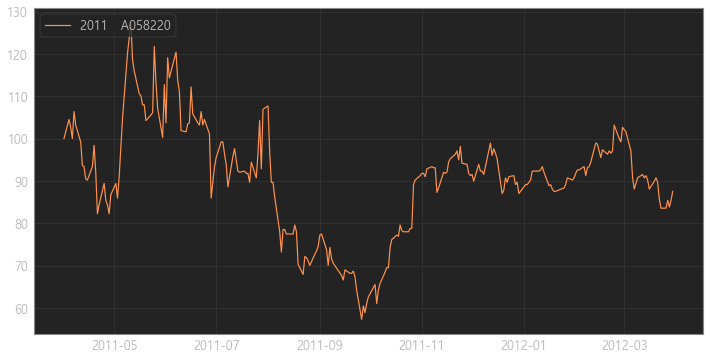

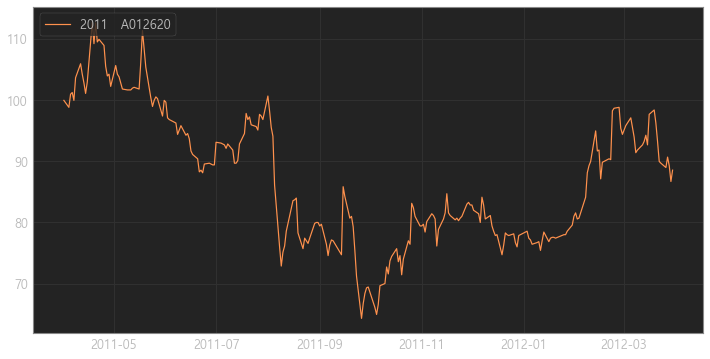

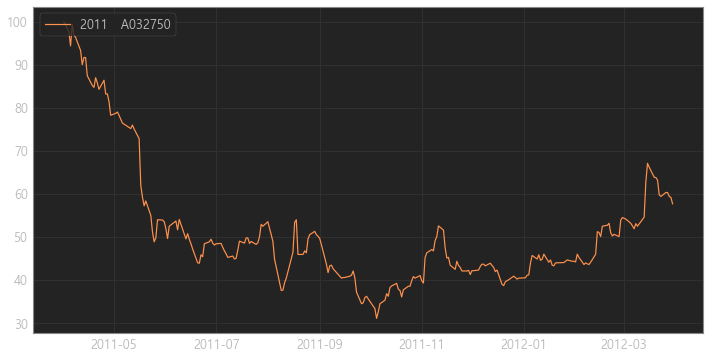

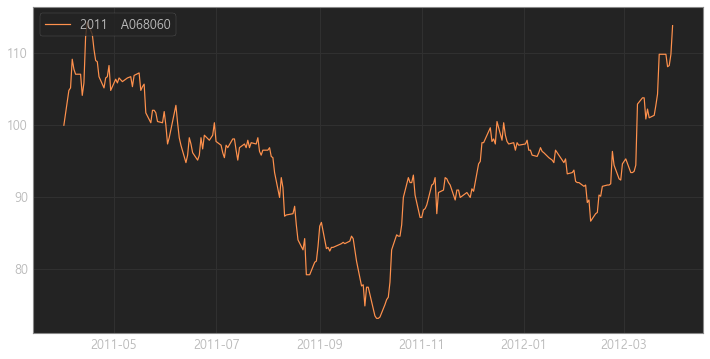

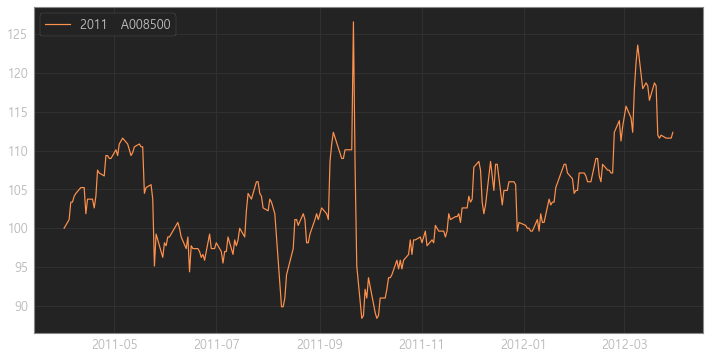

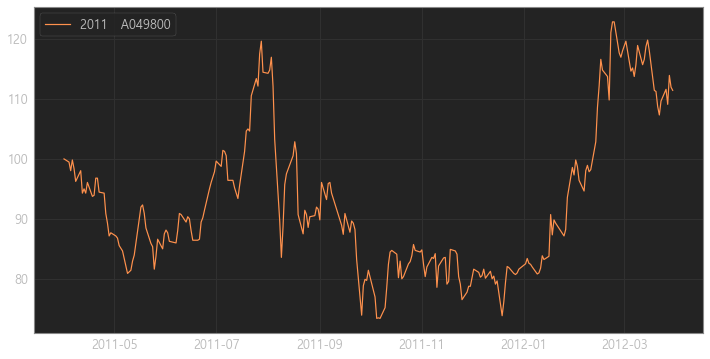

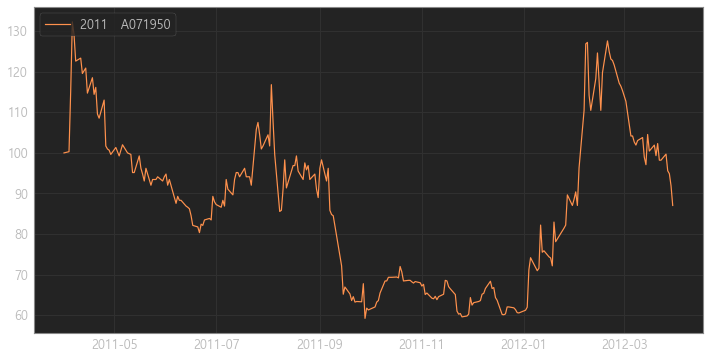

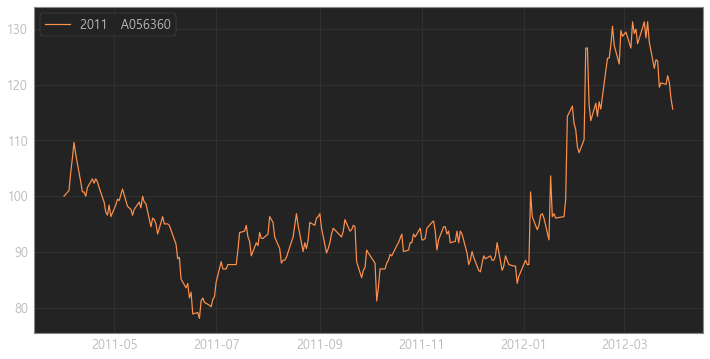

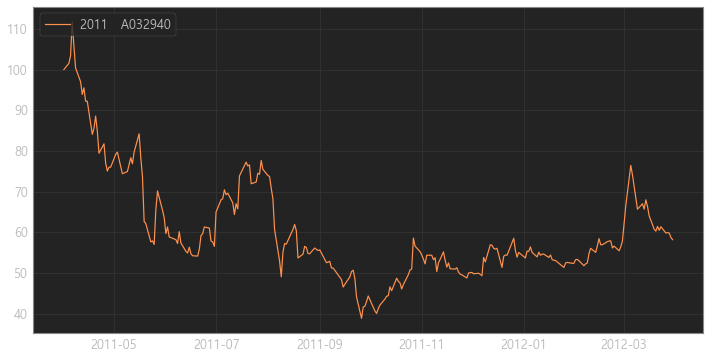

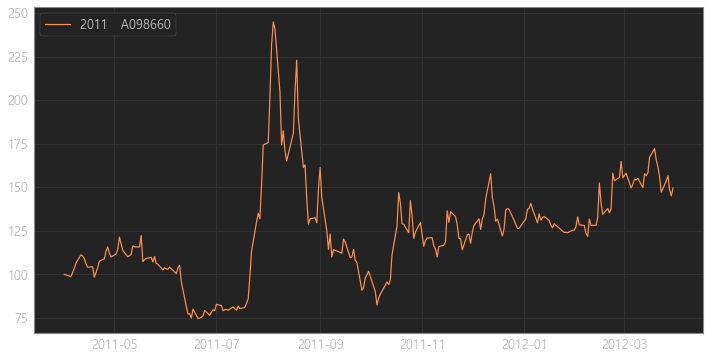

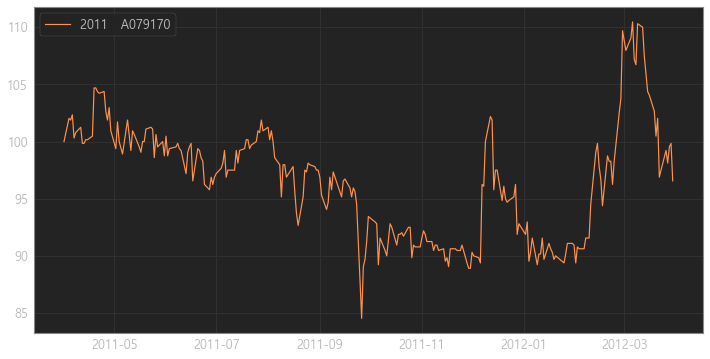

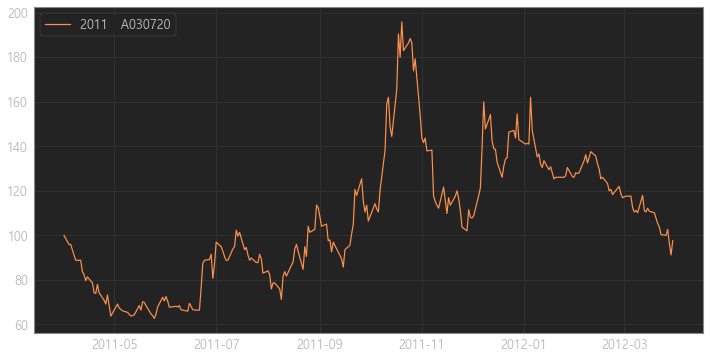

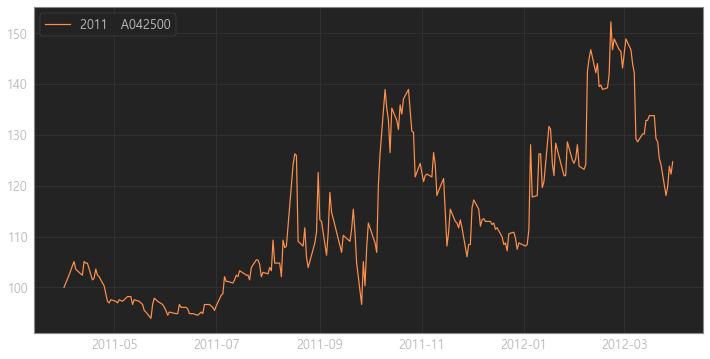

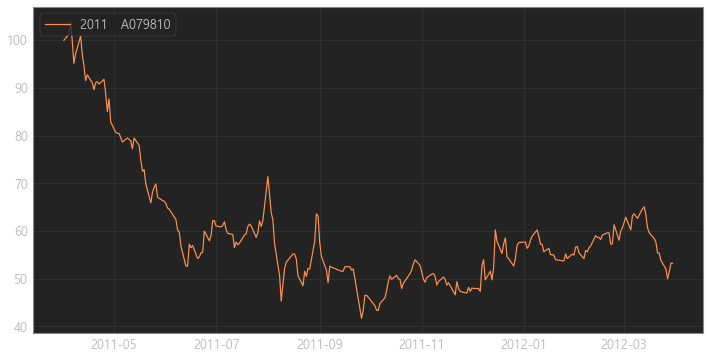

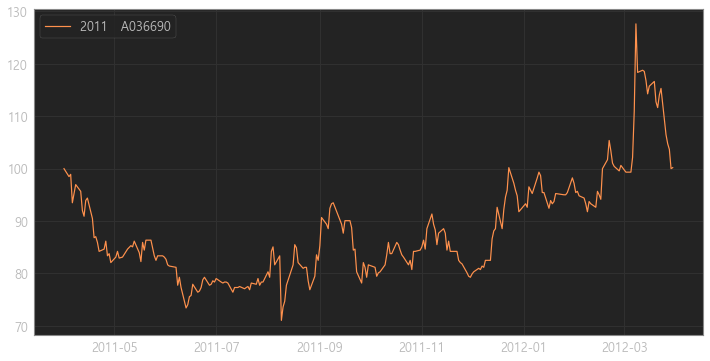

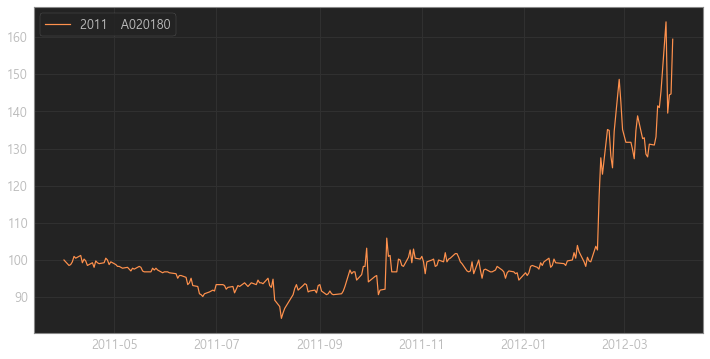

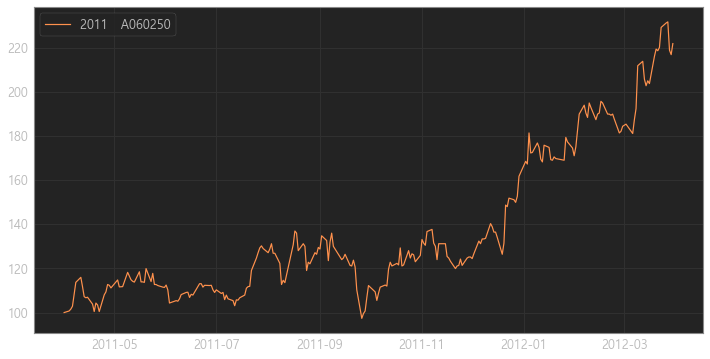

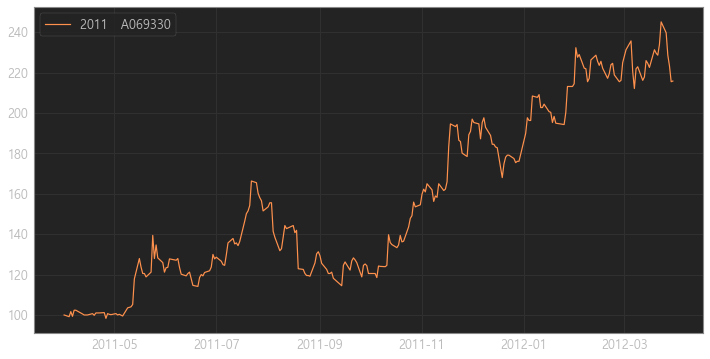

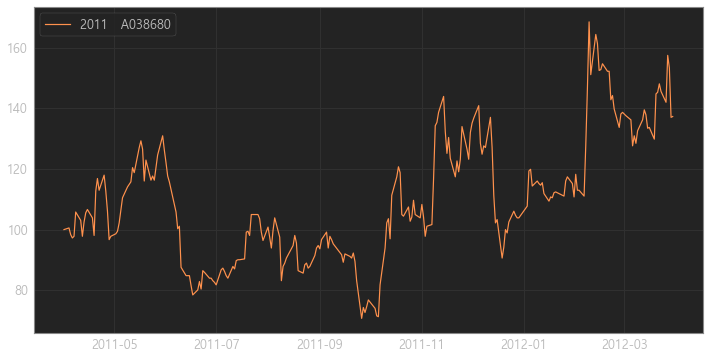

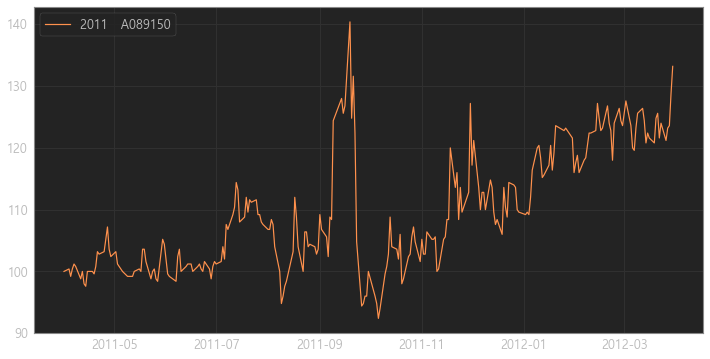

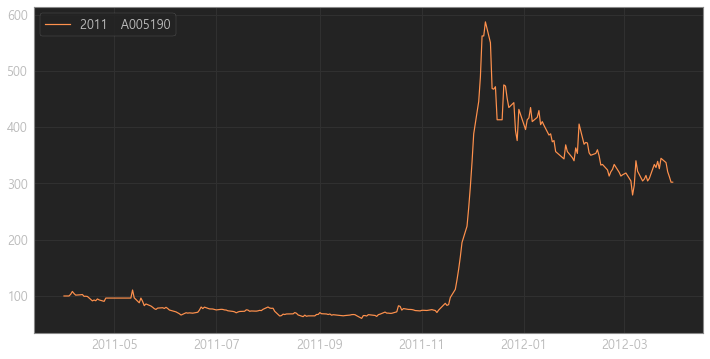

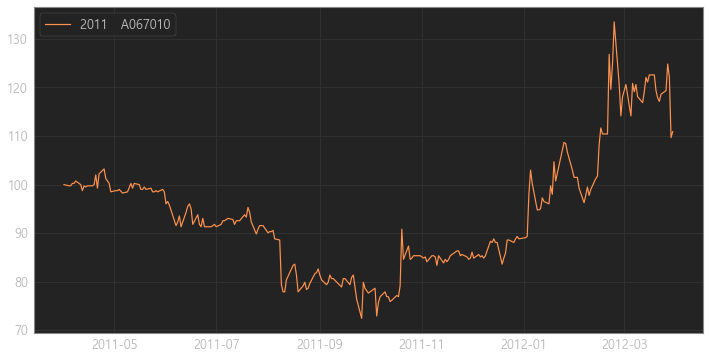

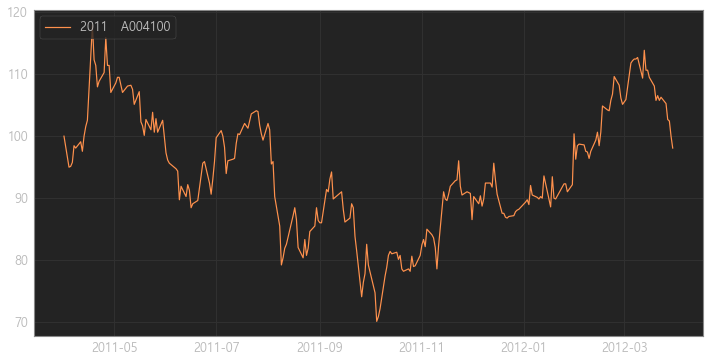

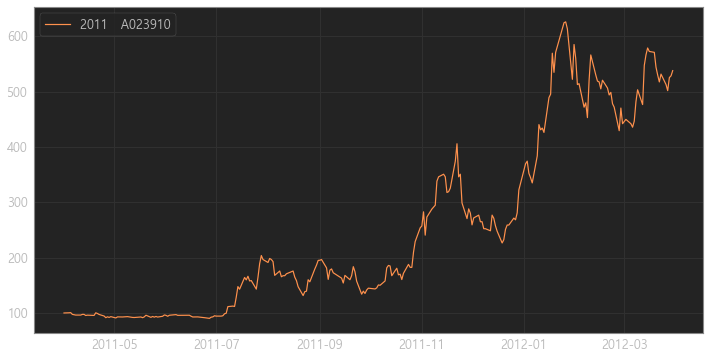

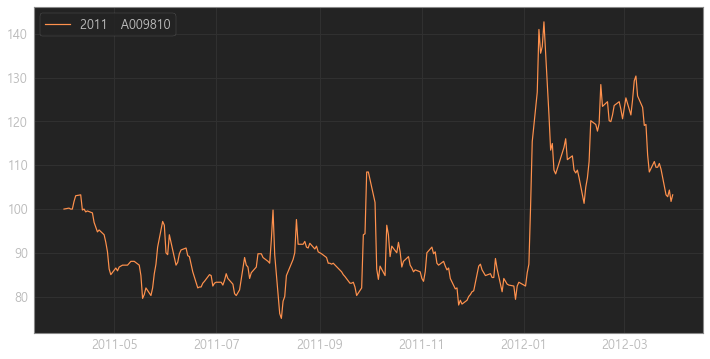

2012


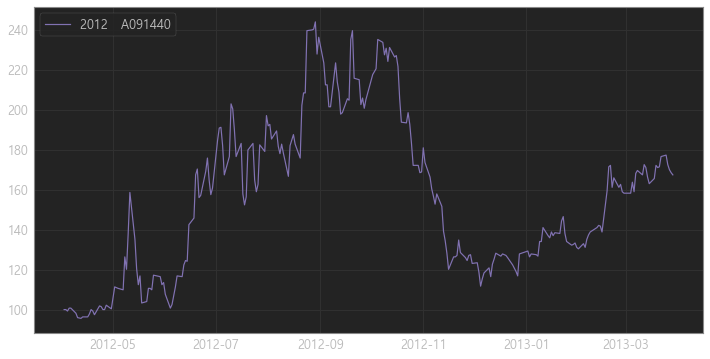

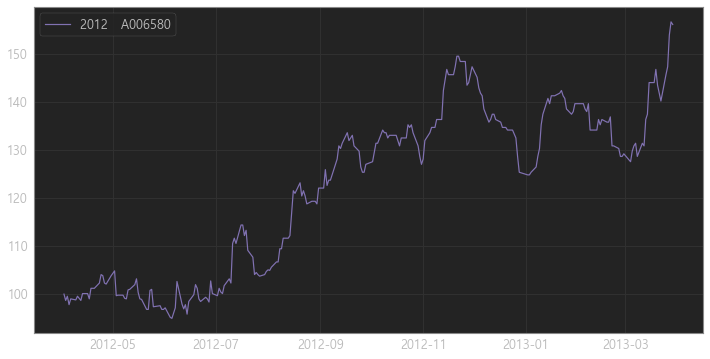

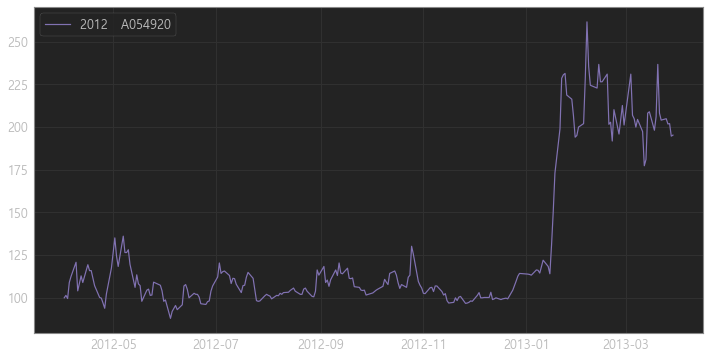

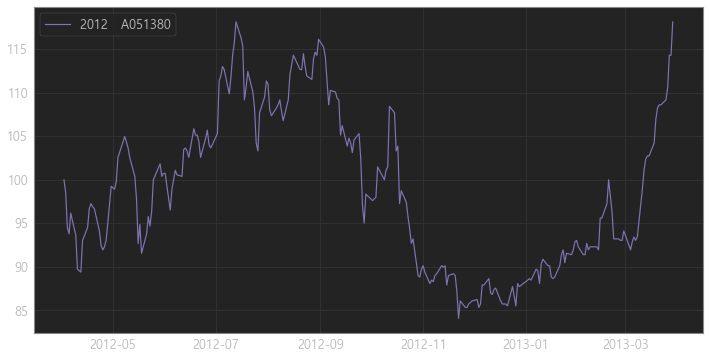

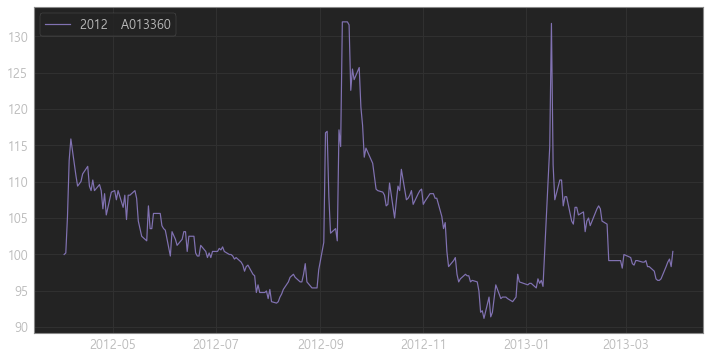

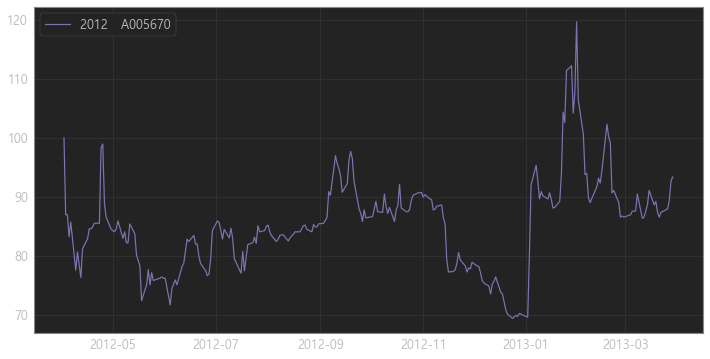

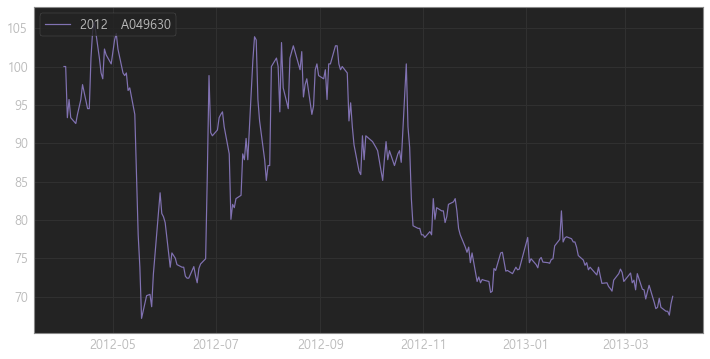

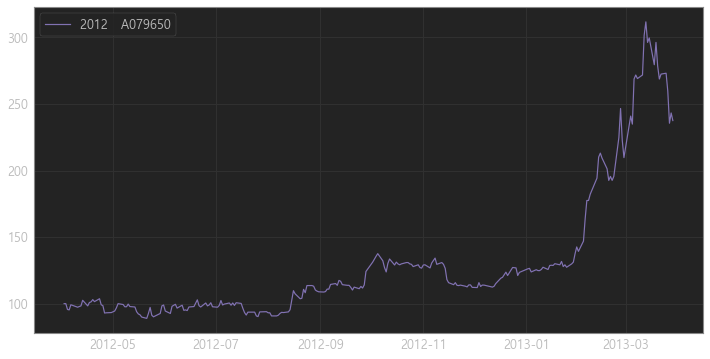

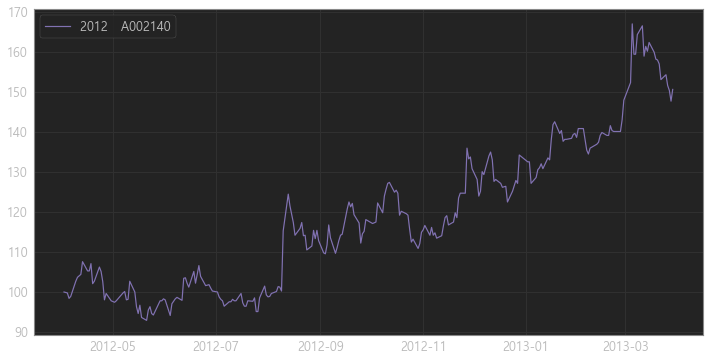

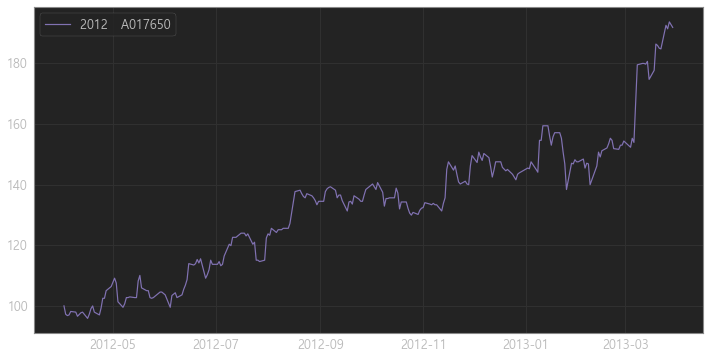

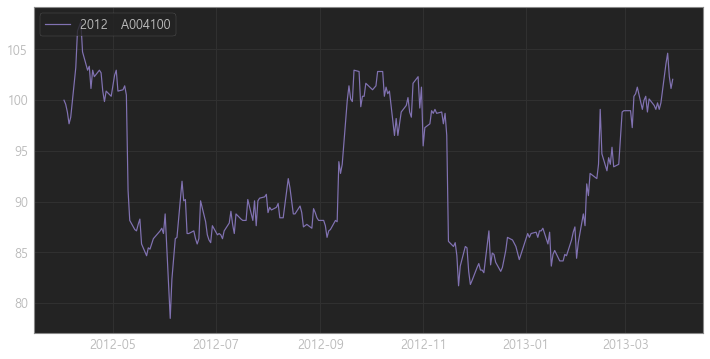

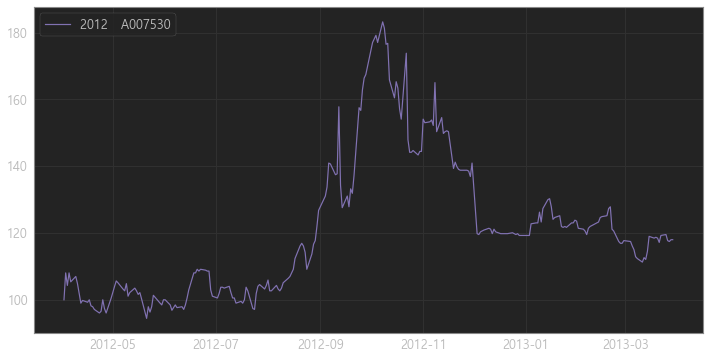

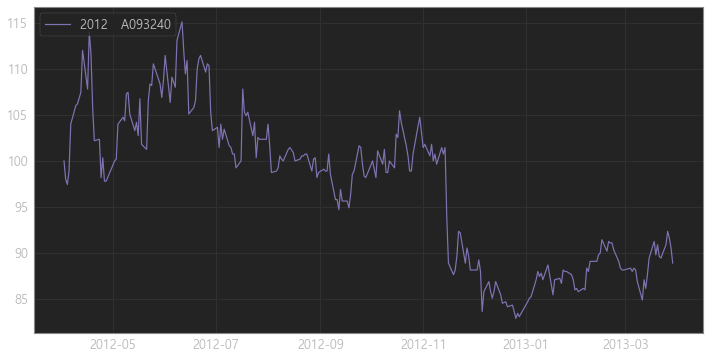

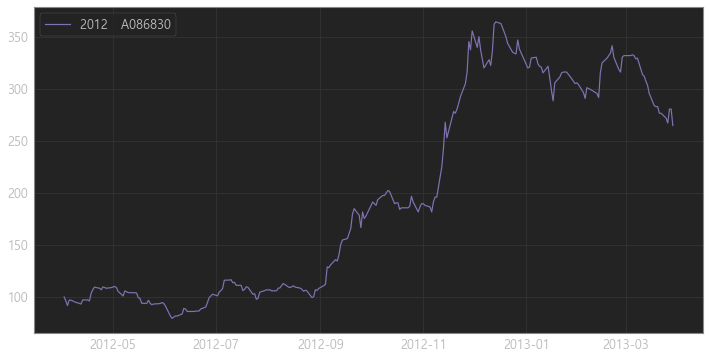

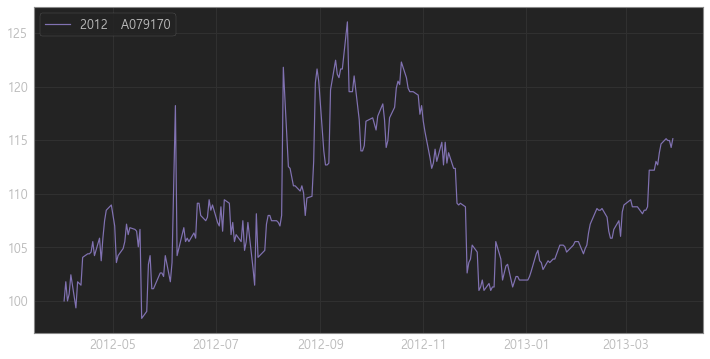

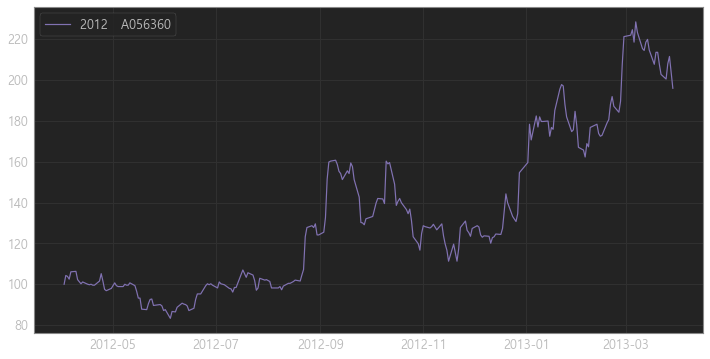

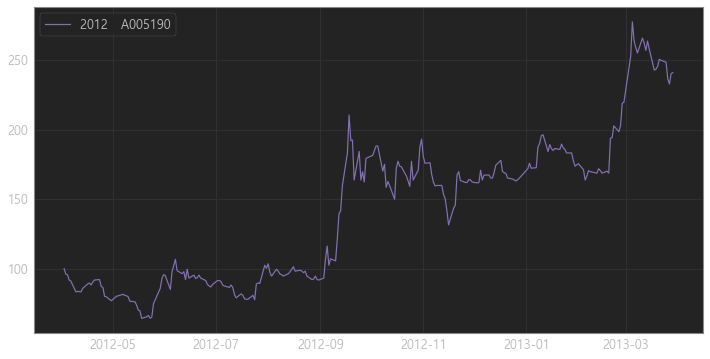

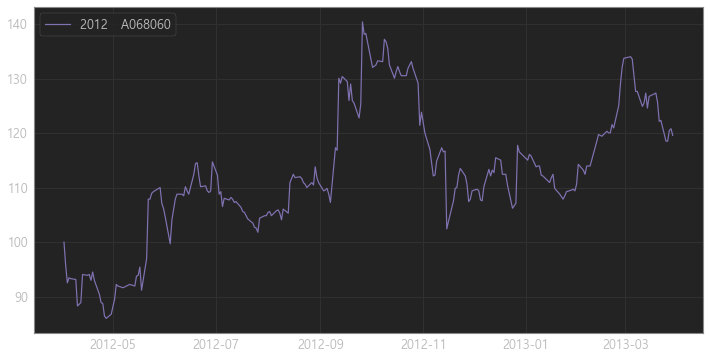

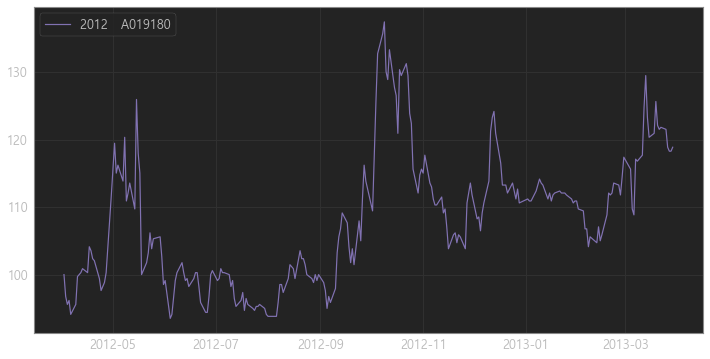

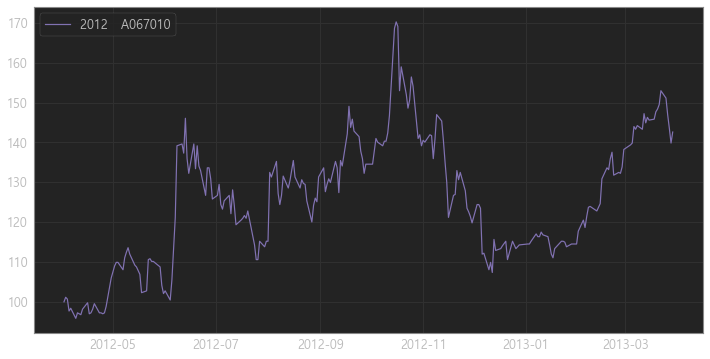

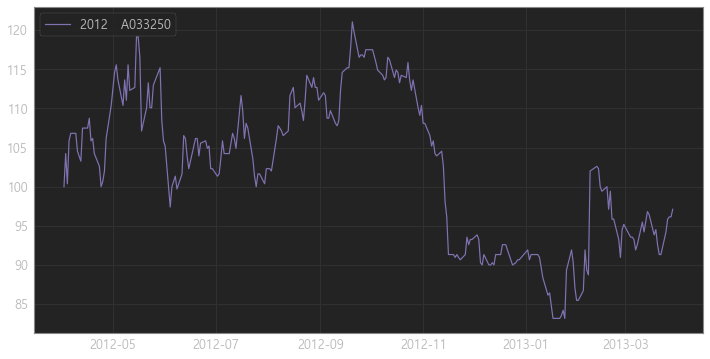

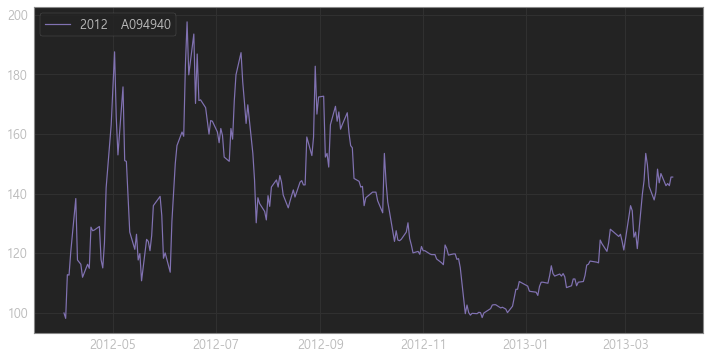

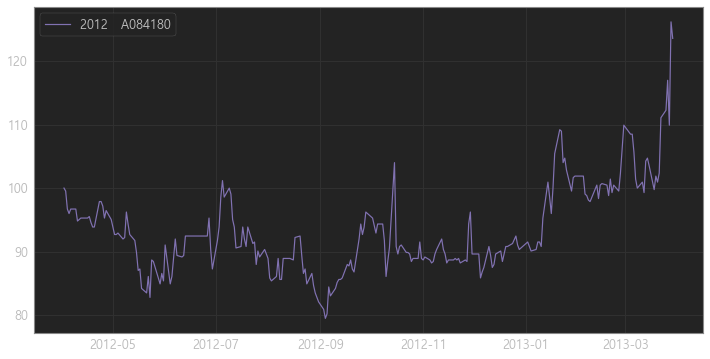

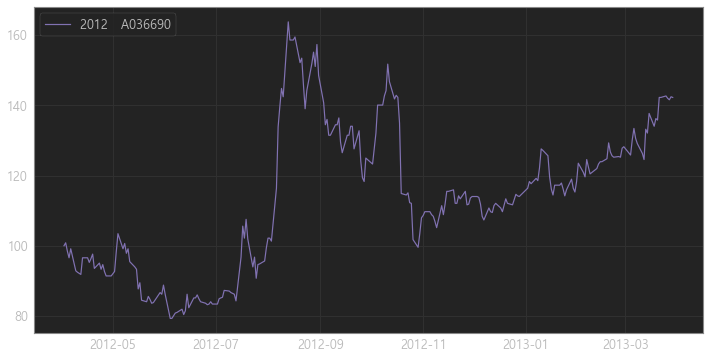

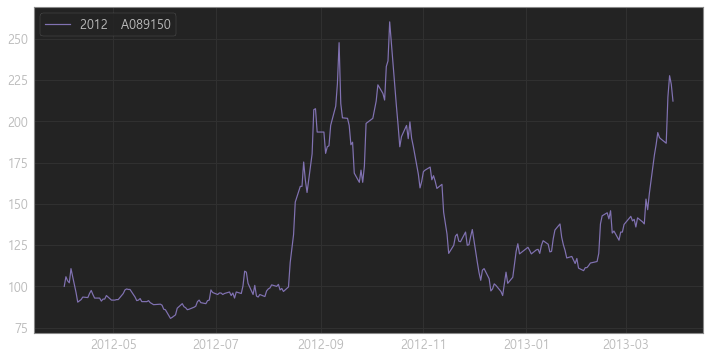

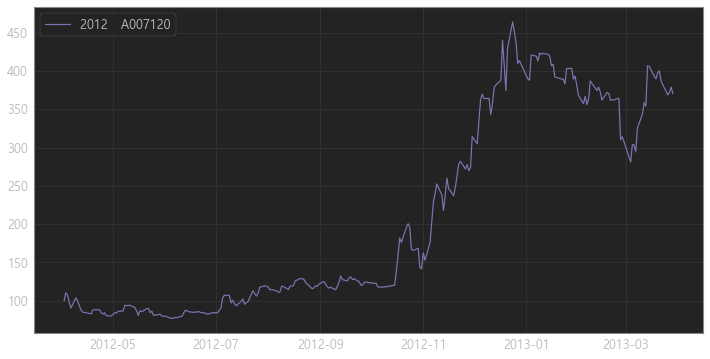

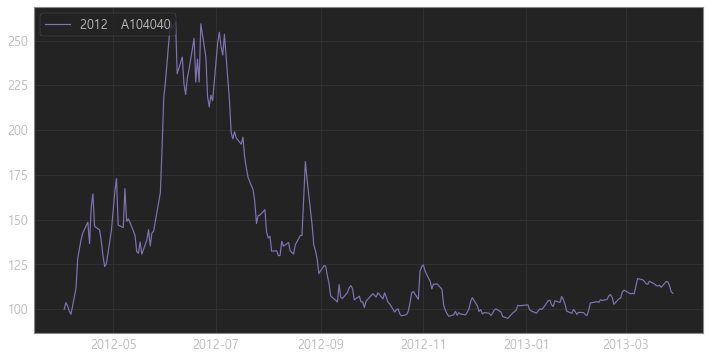

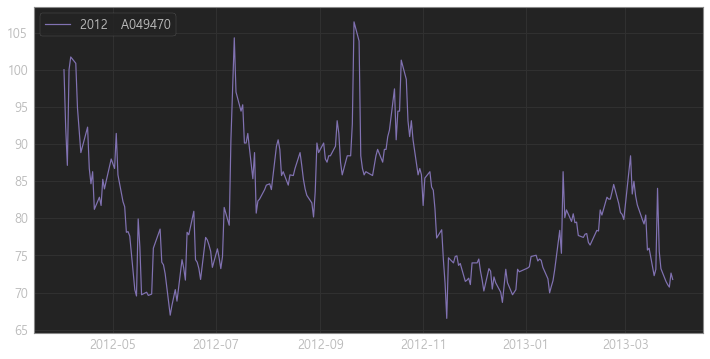

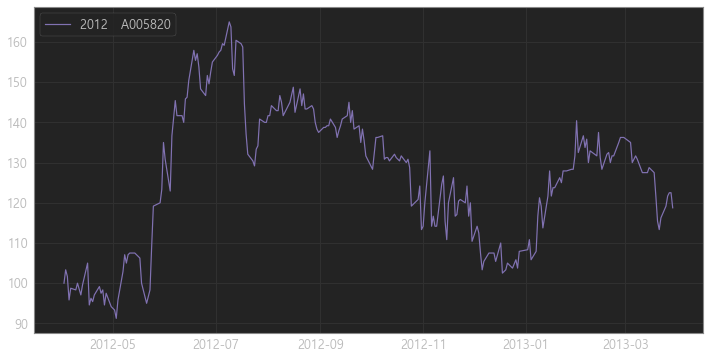

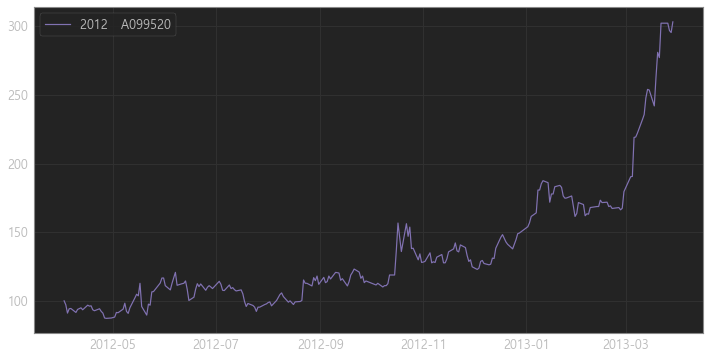

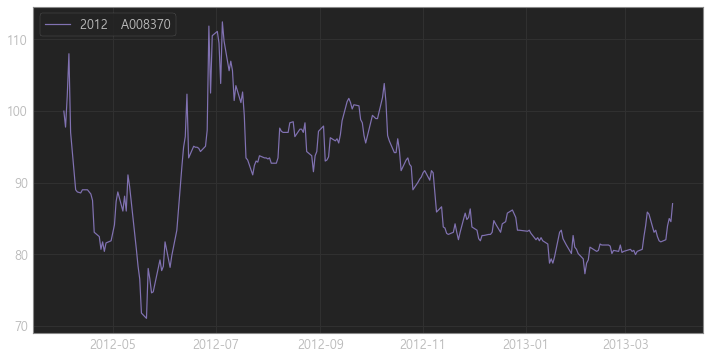

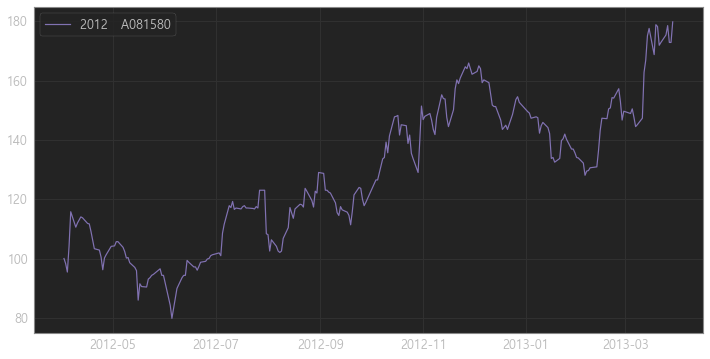

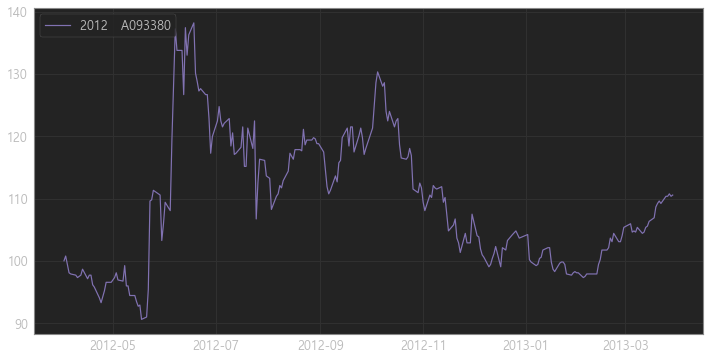

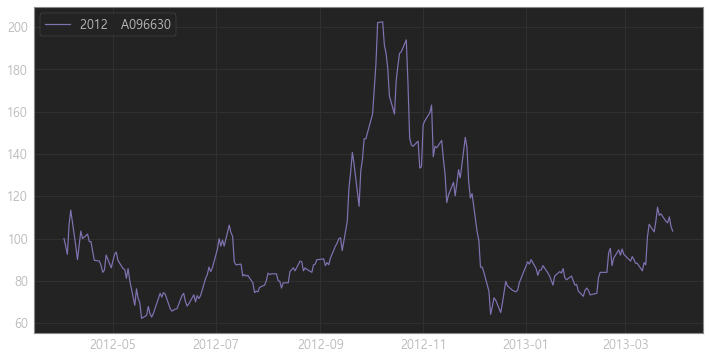

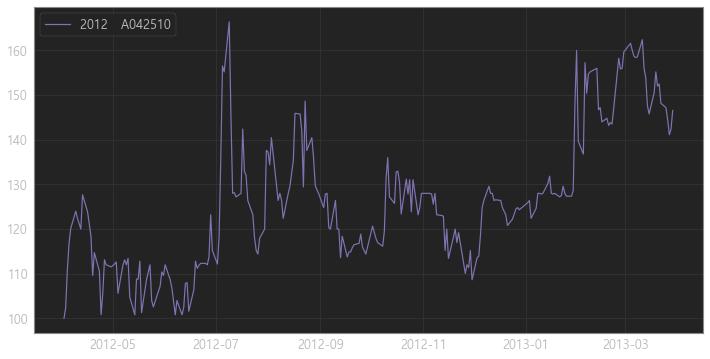

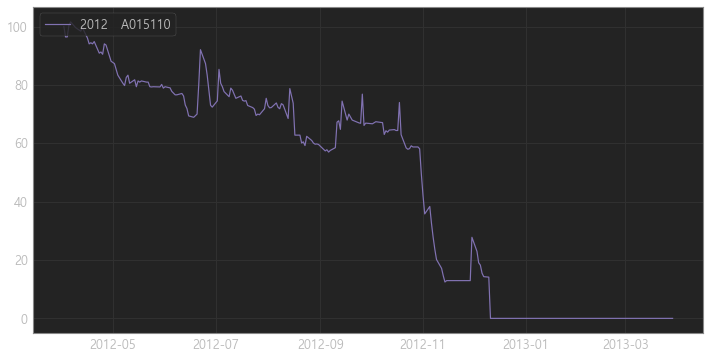

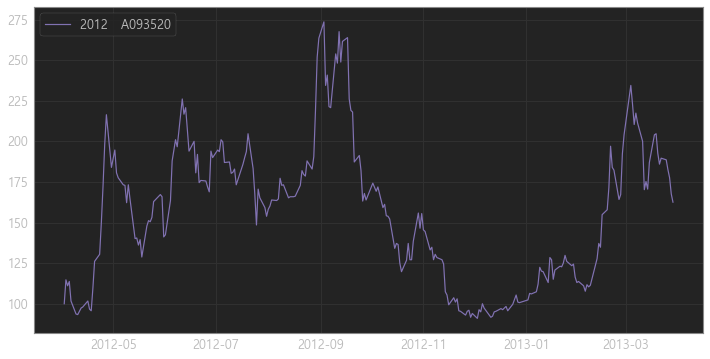

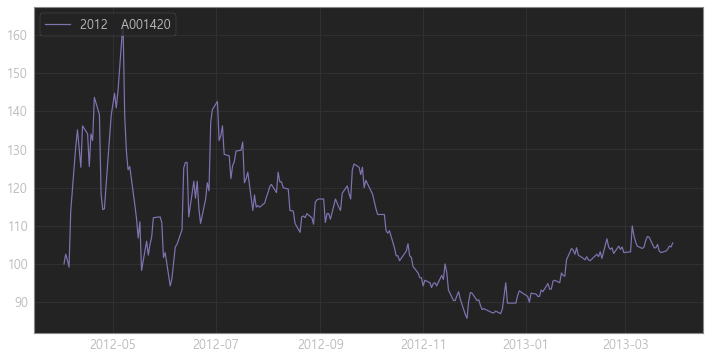

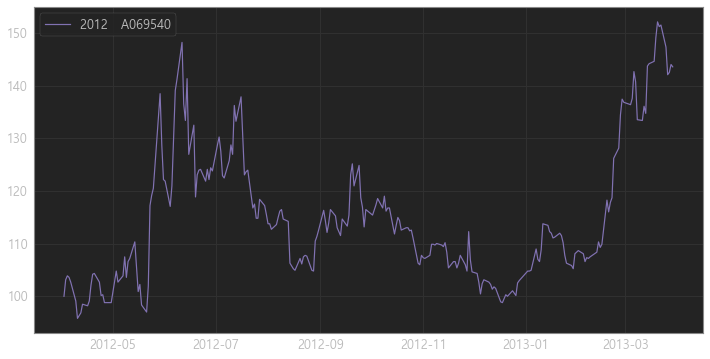

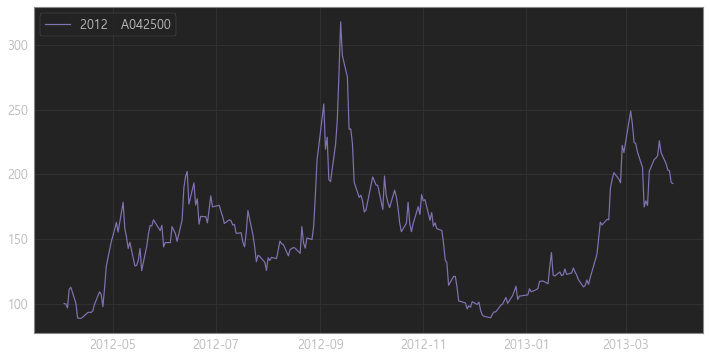

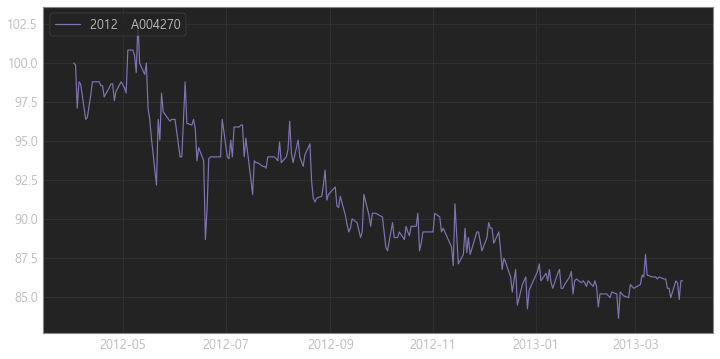

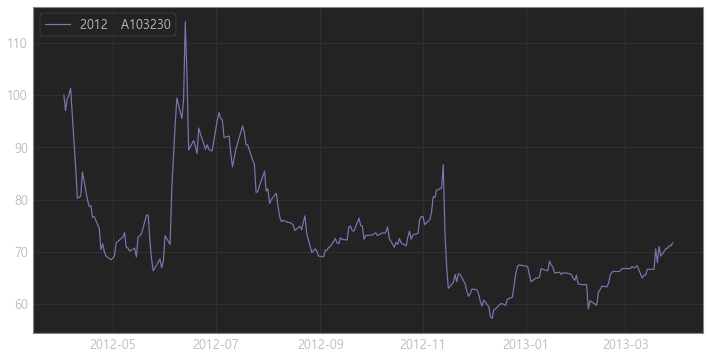

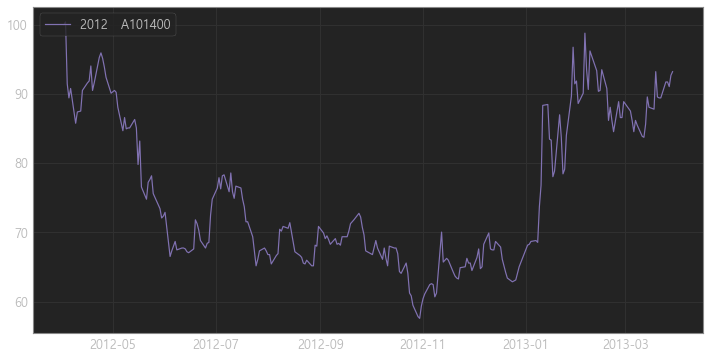

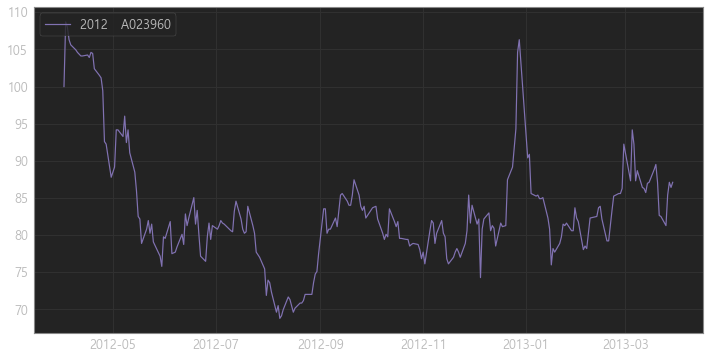

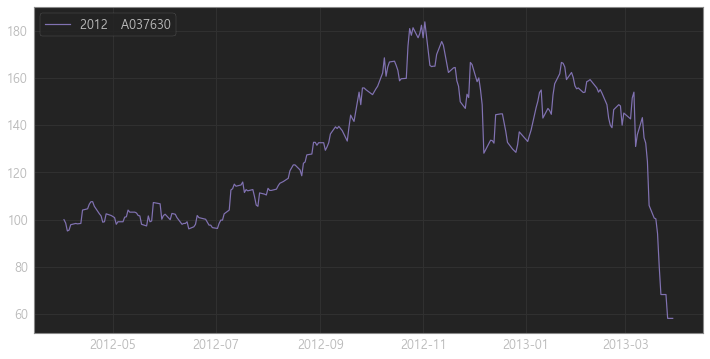

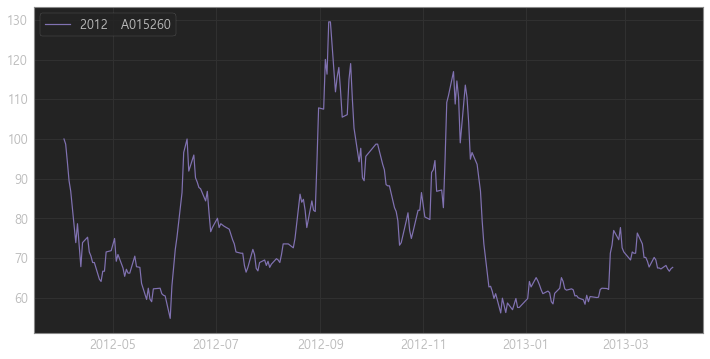

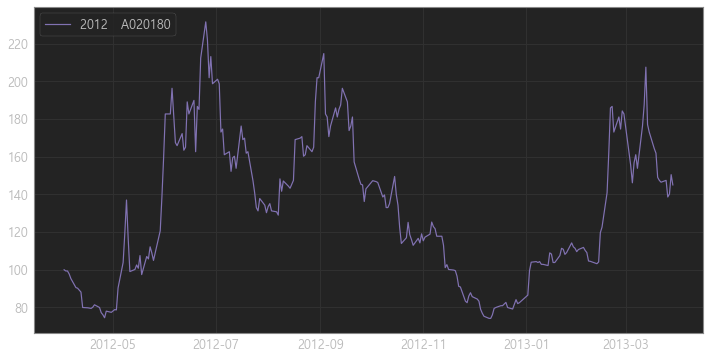

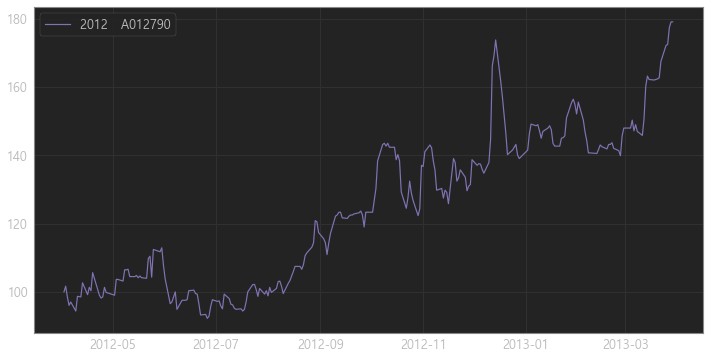

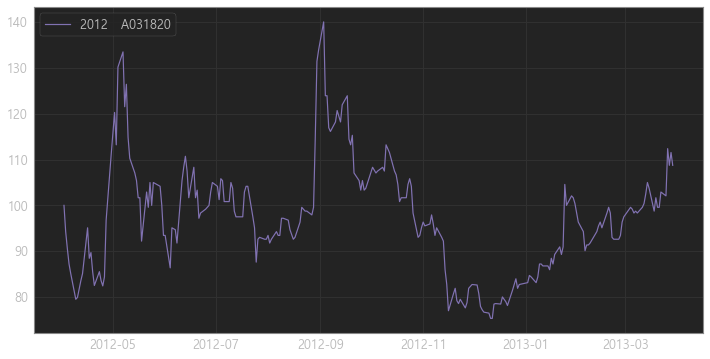

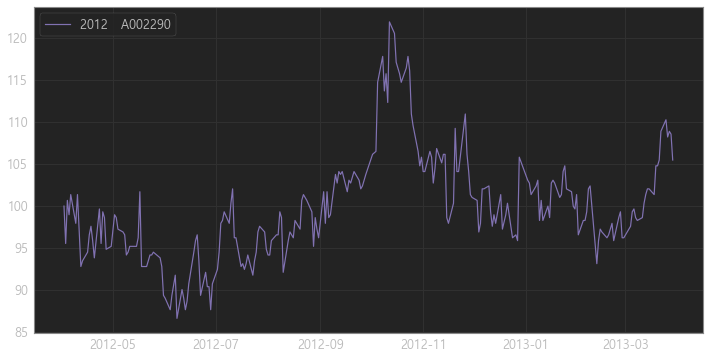

2013


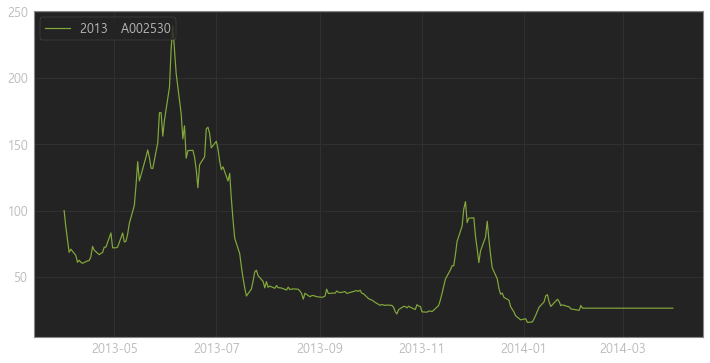

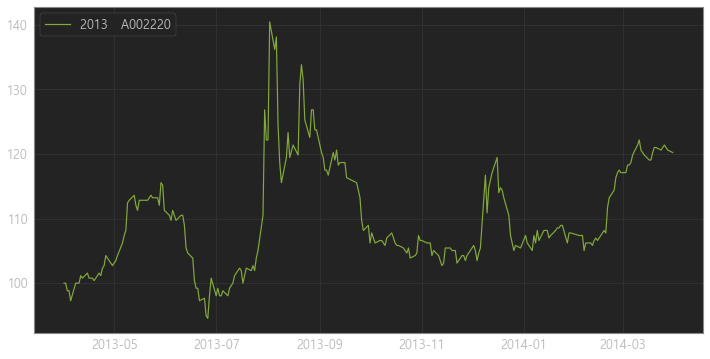

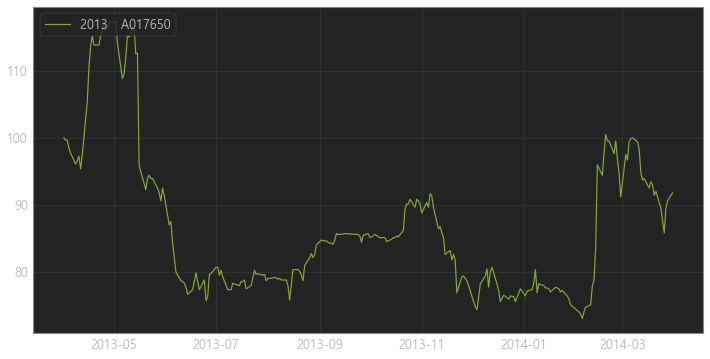

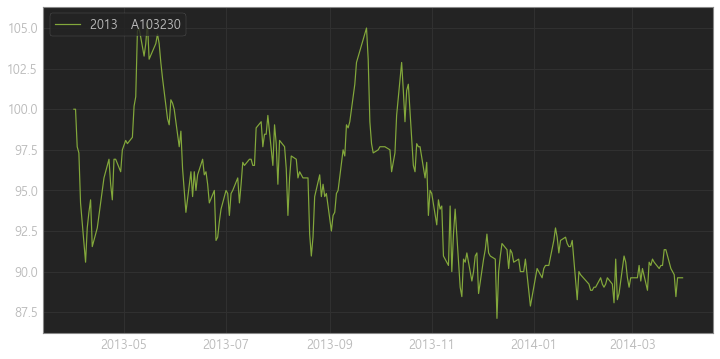

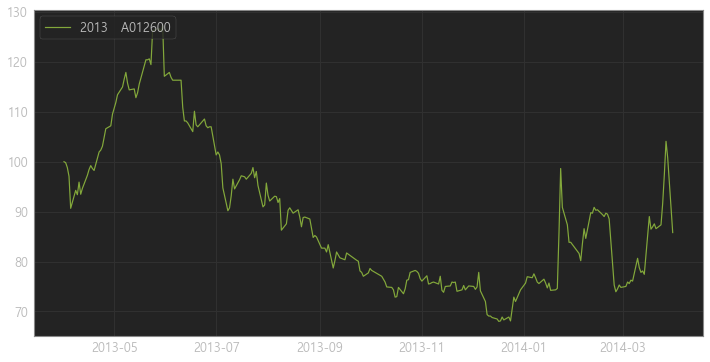

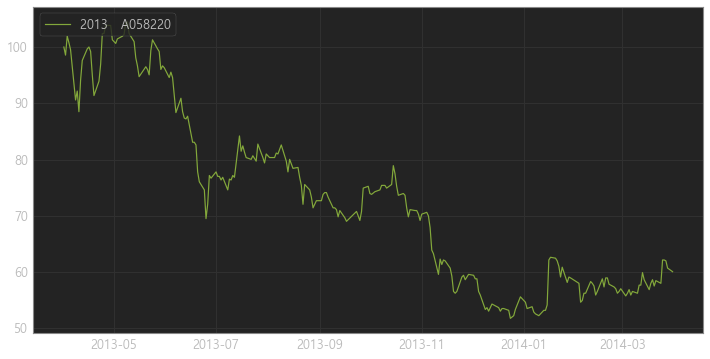

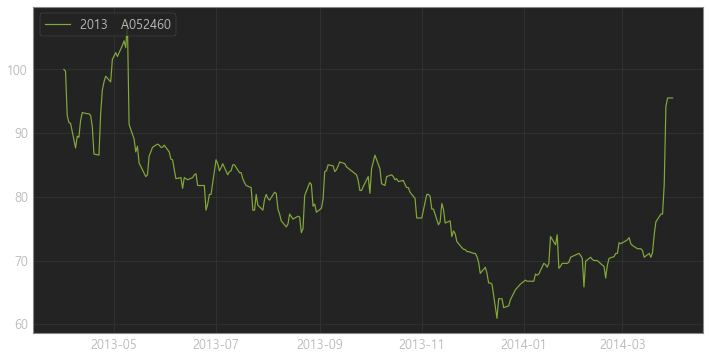

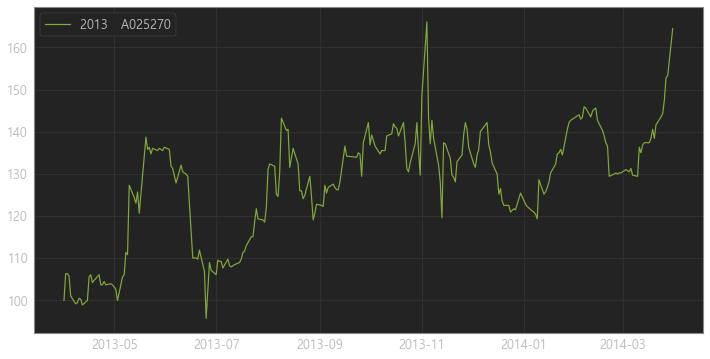

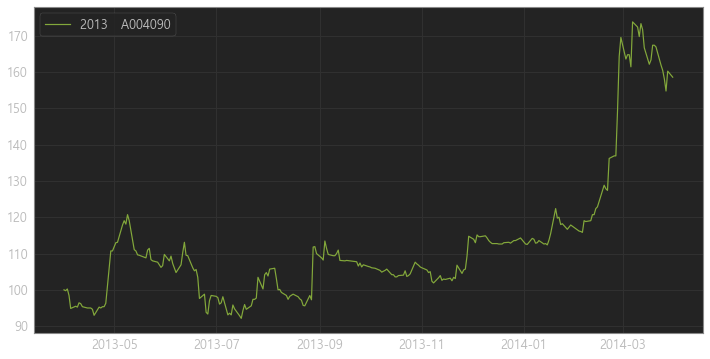

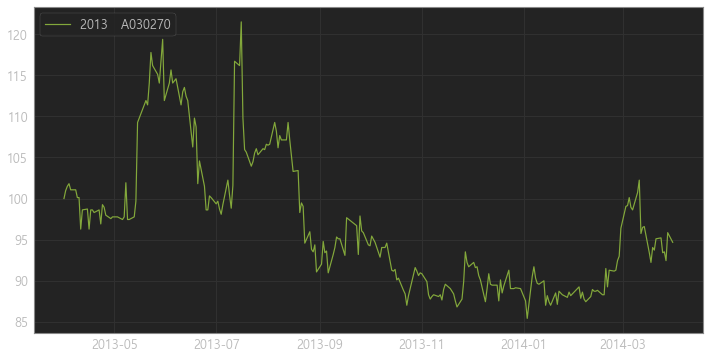

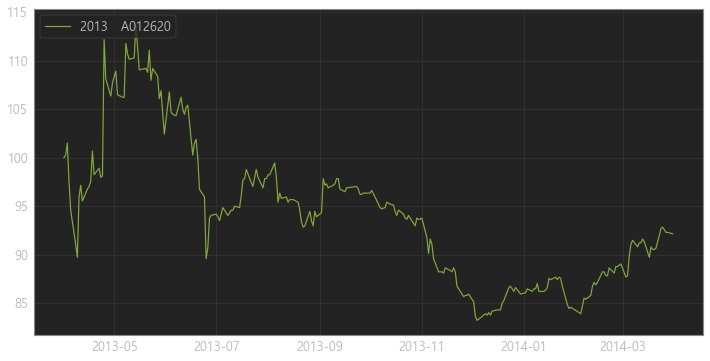

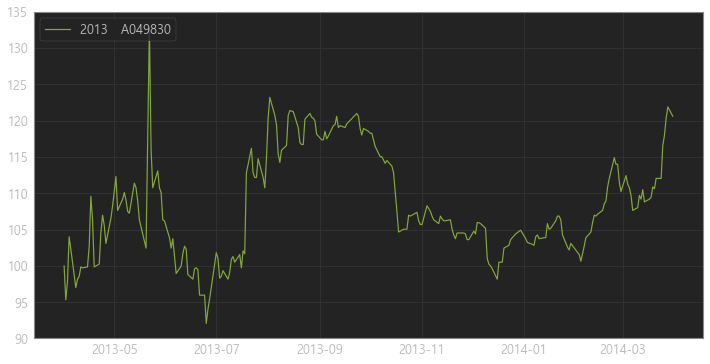

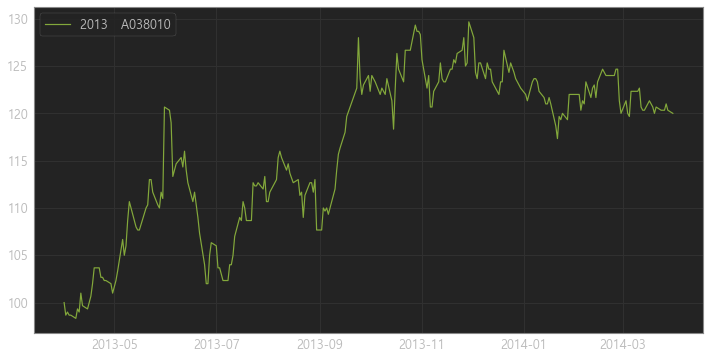

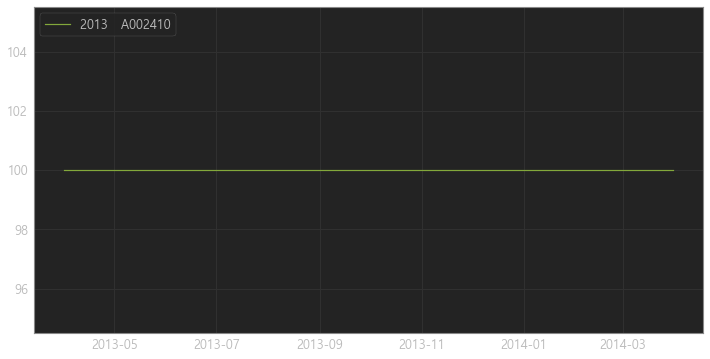

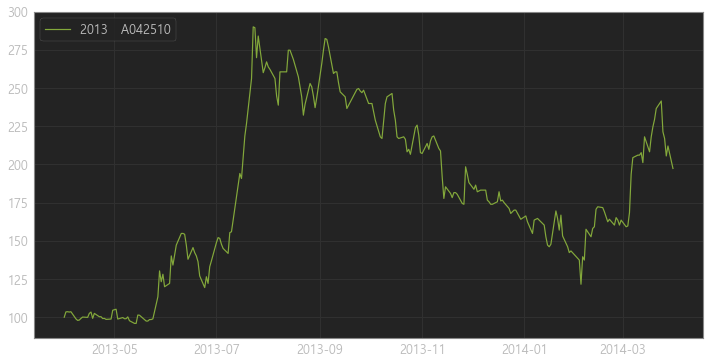

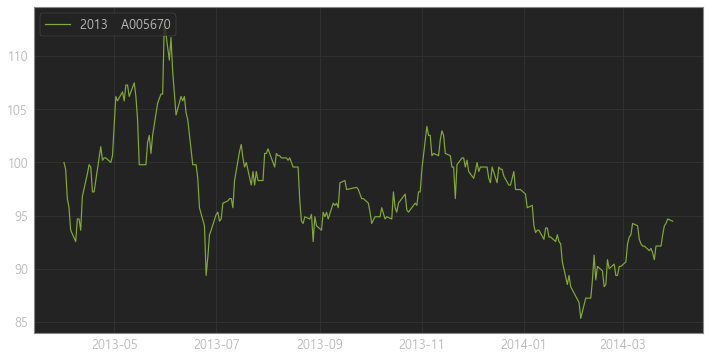

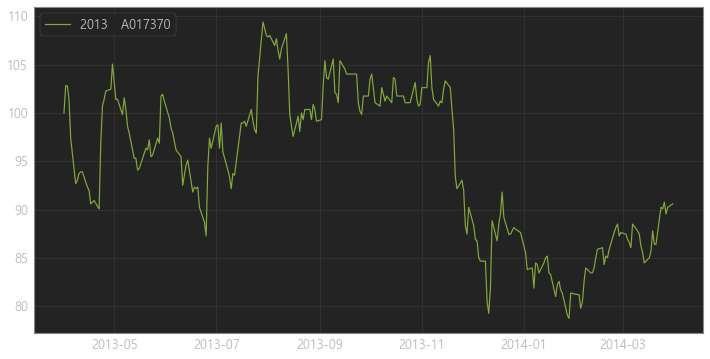

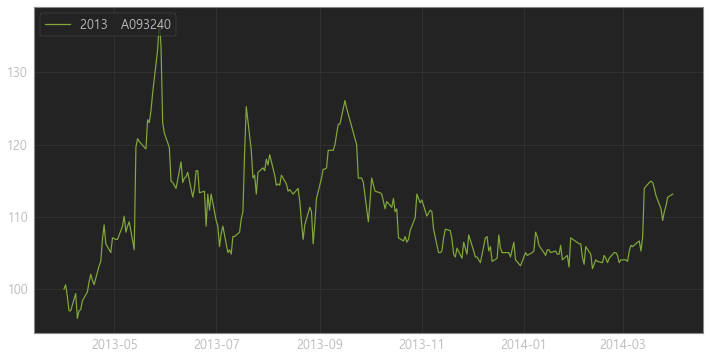

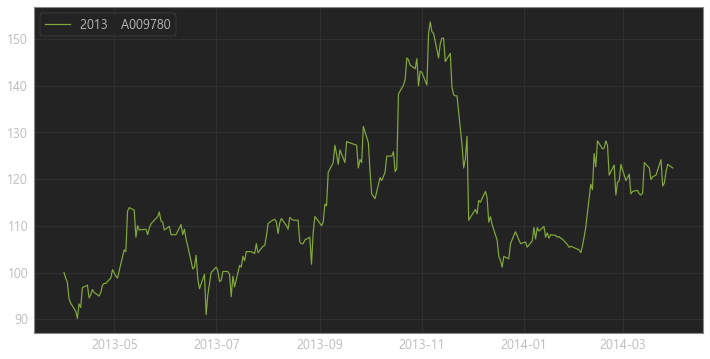

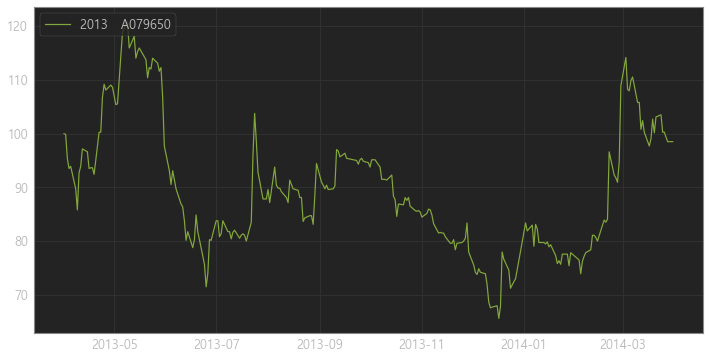

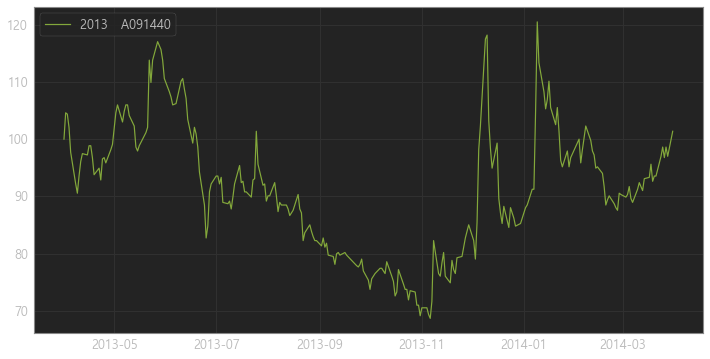

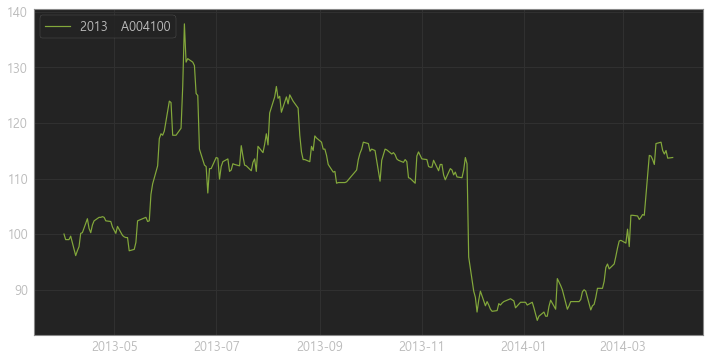

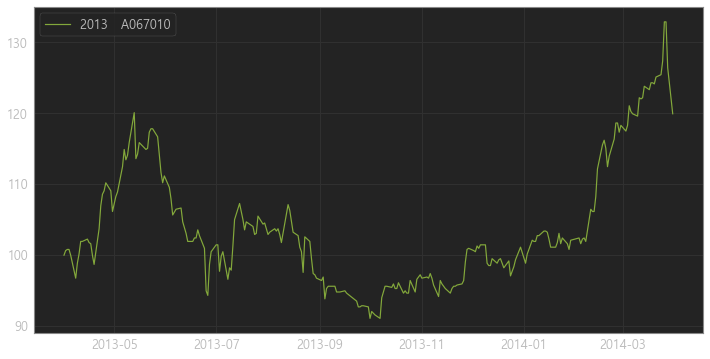

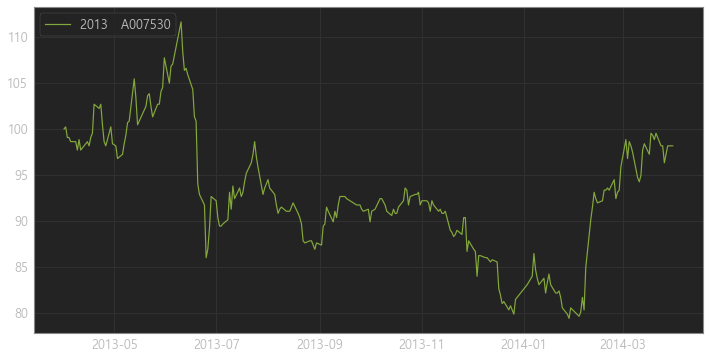

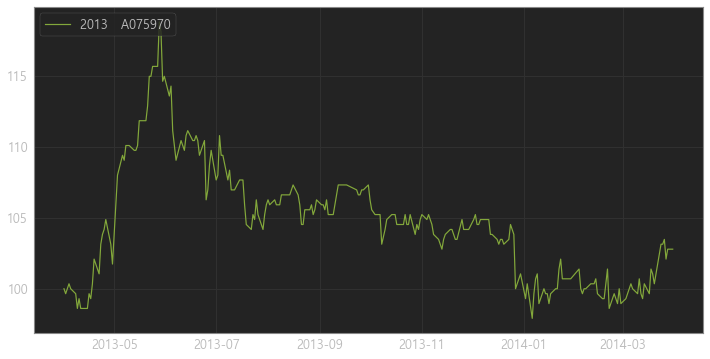

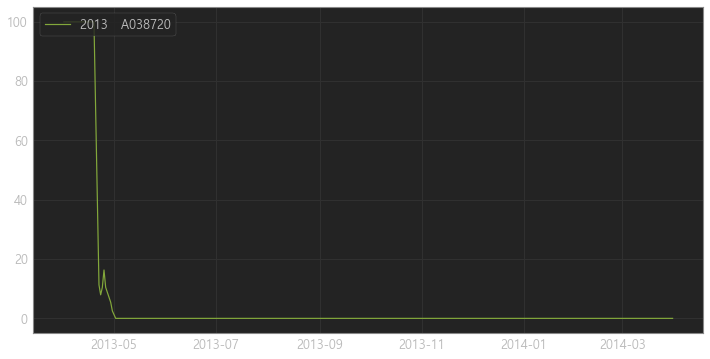

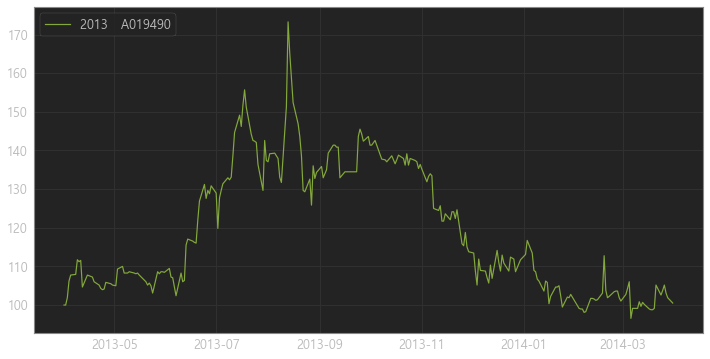

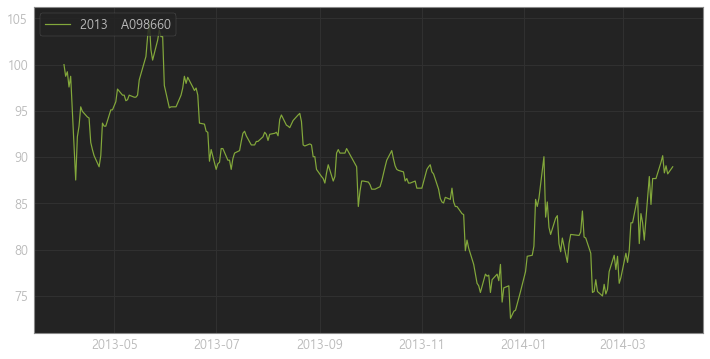

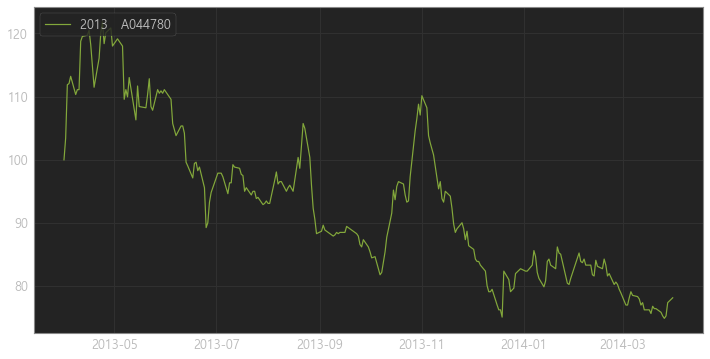

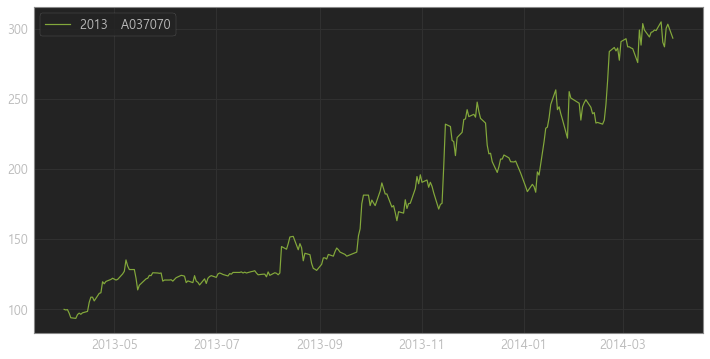

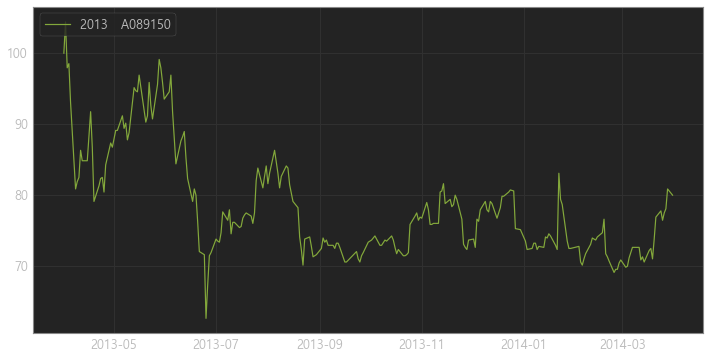

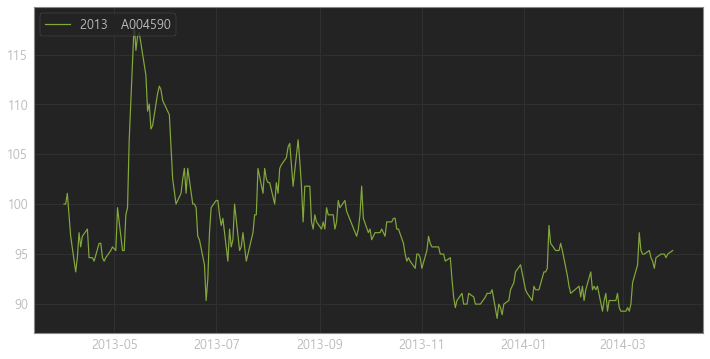

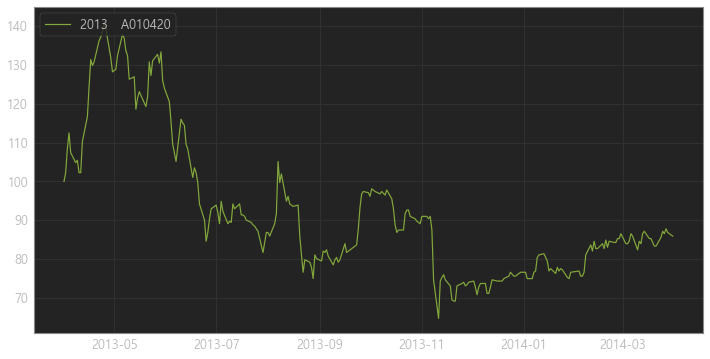

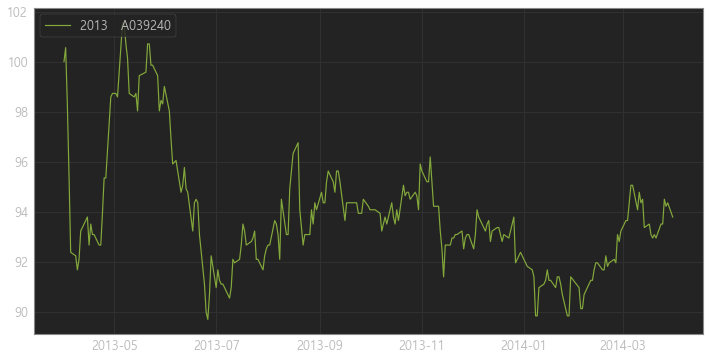

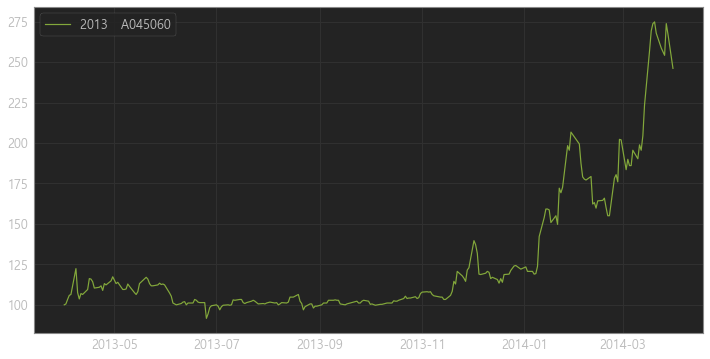

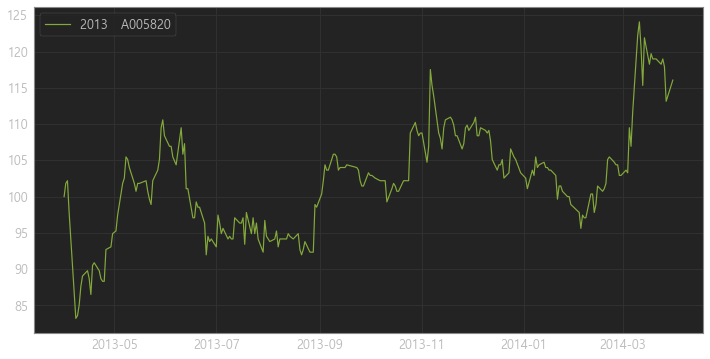

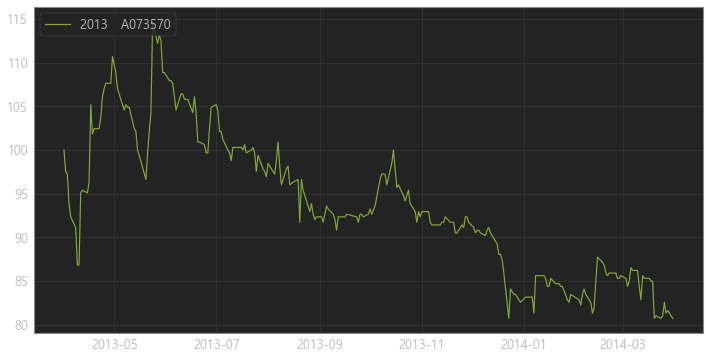

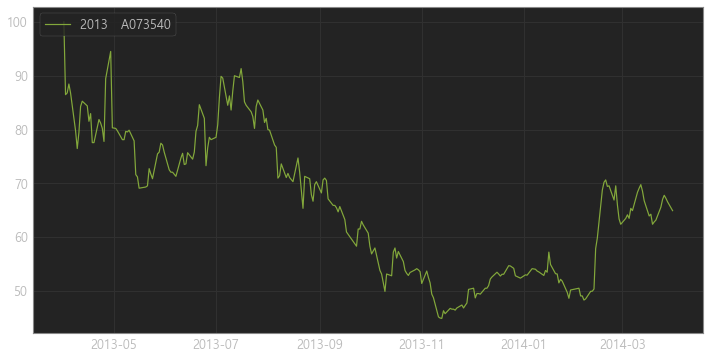

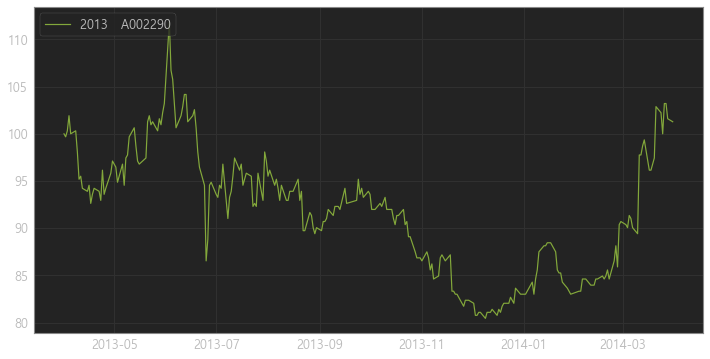

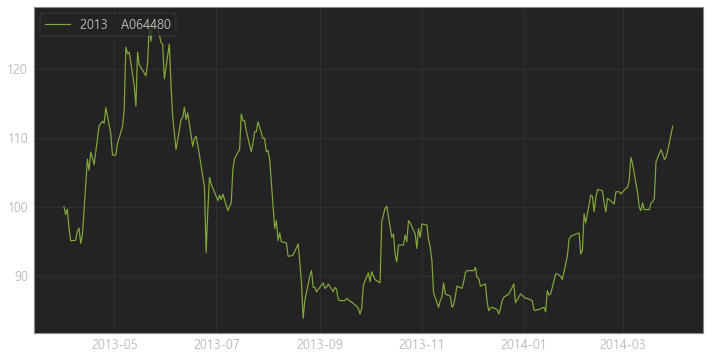

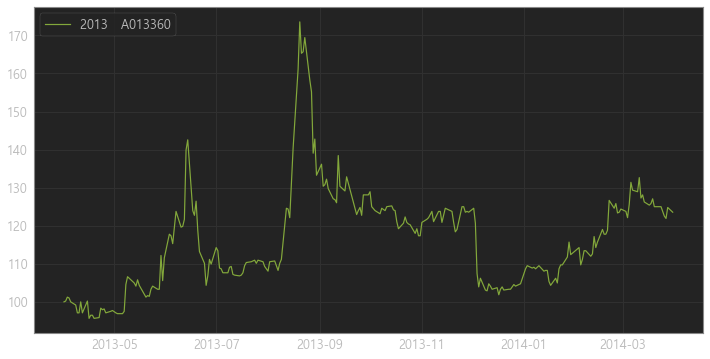

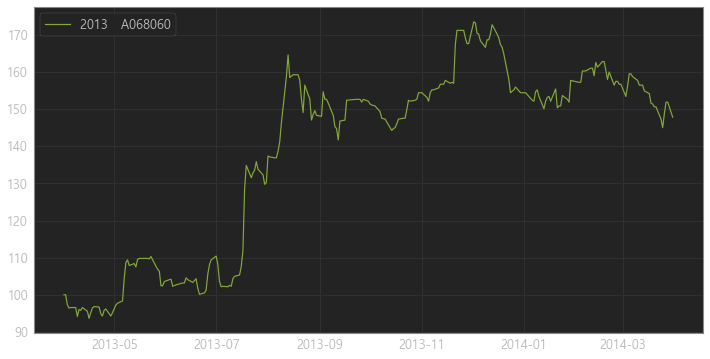

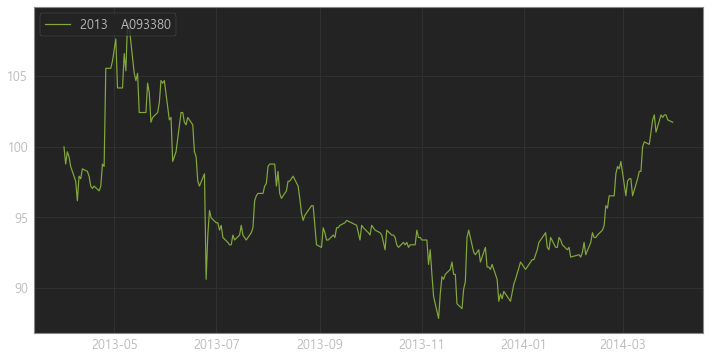

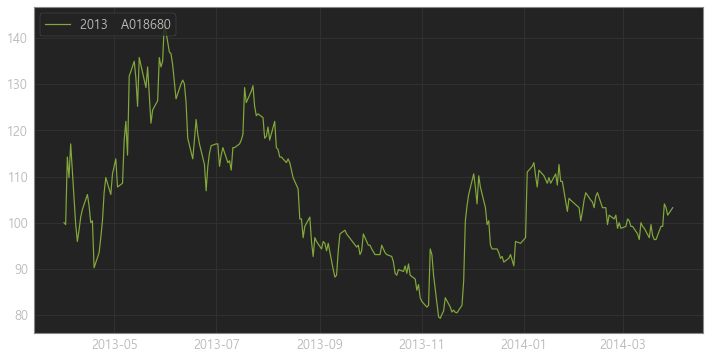

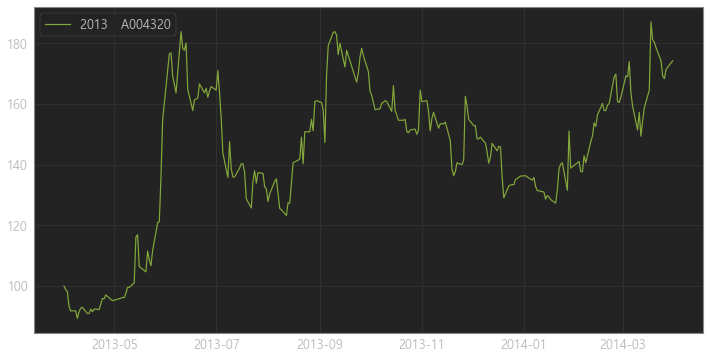

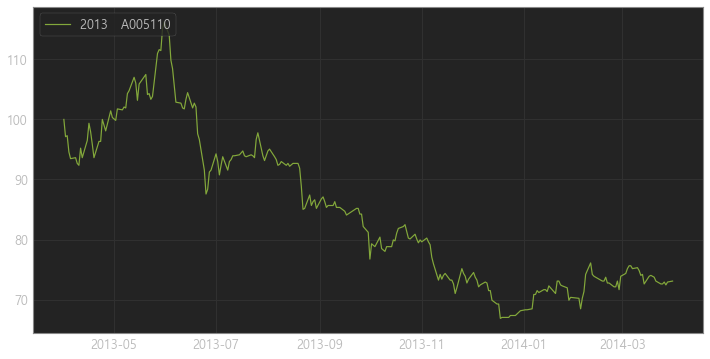

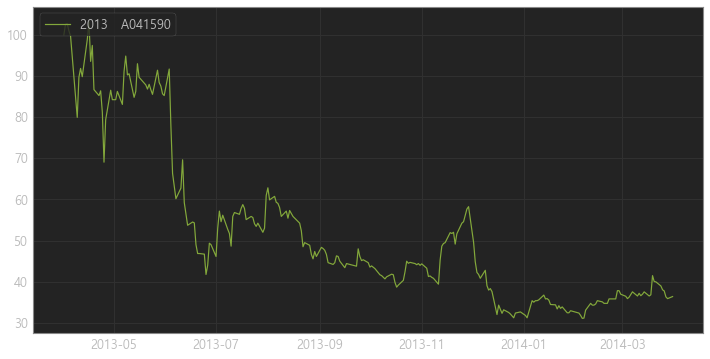

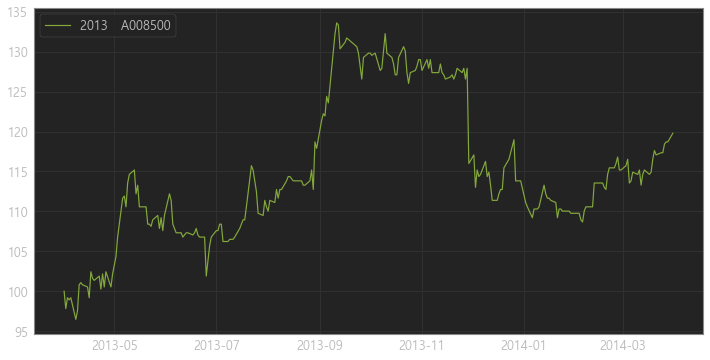

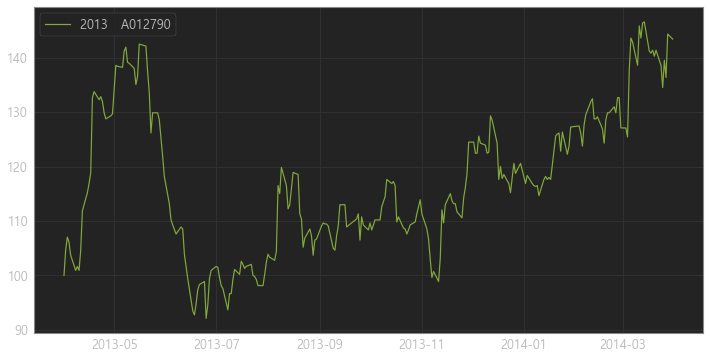

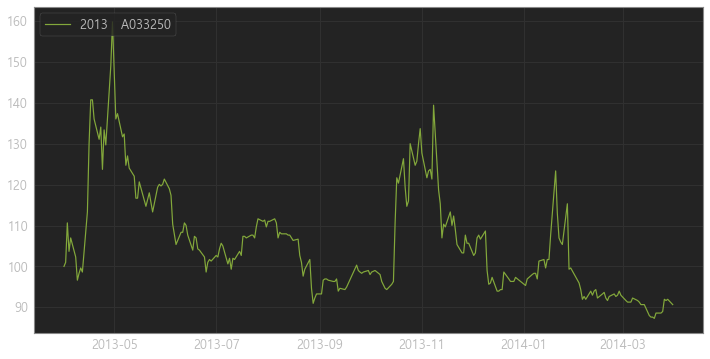

2014


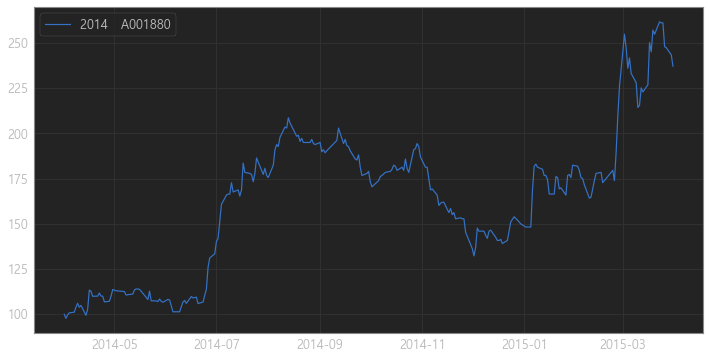

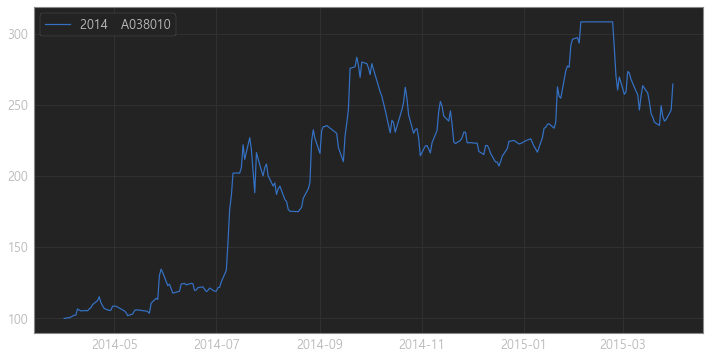

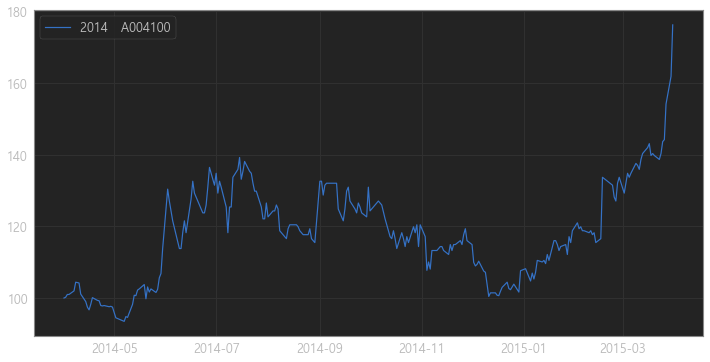

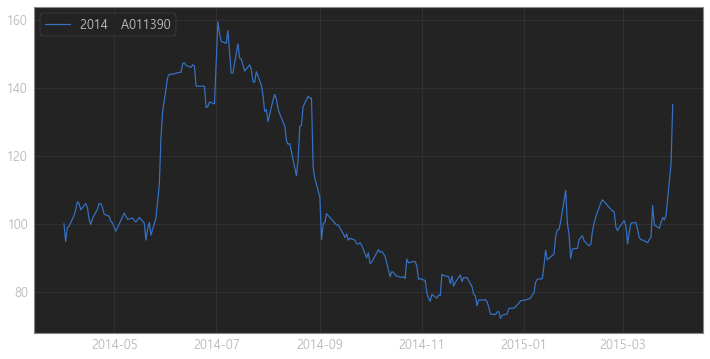

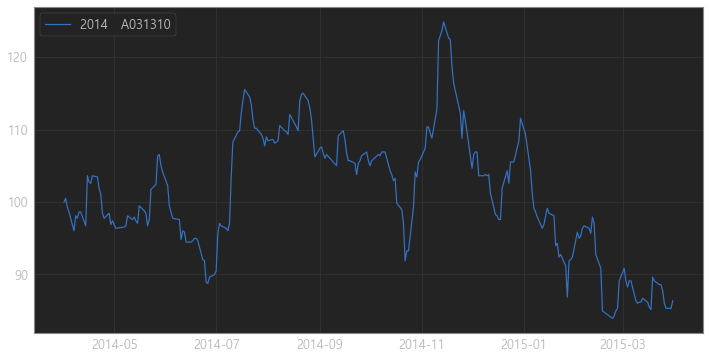

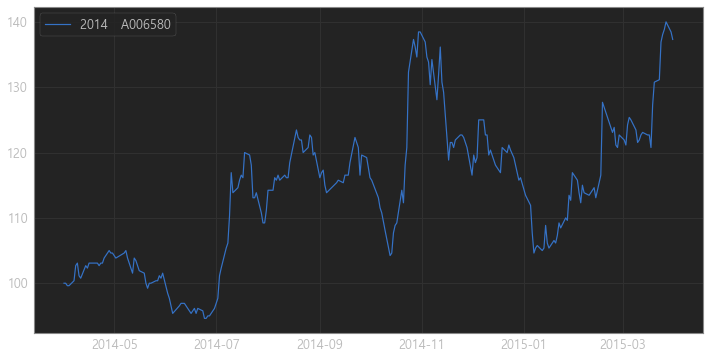

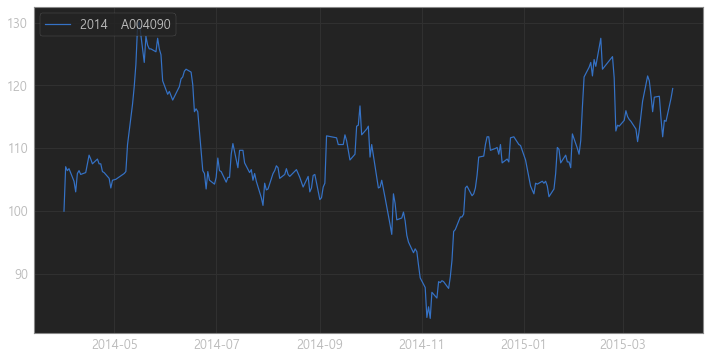

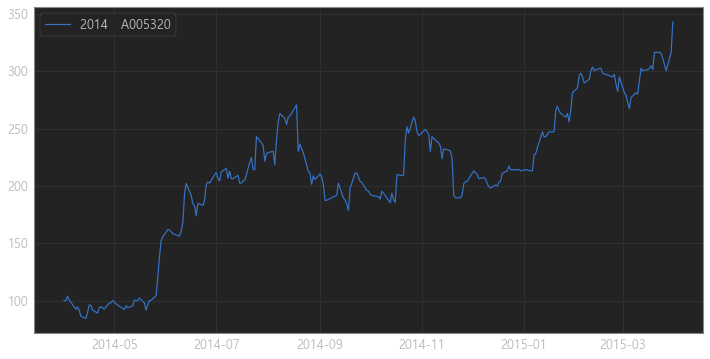

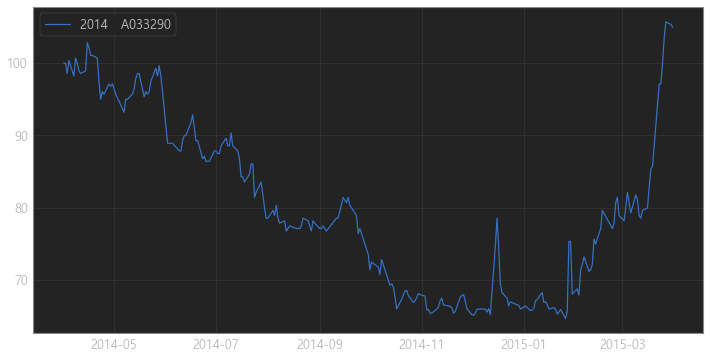

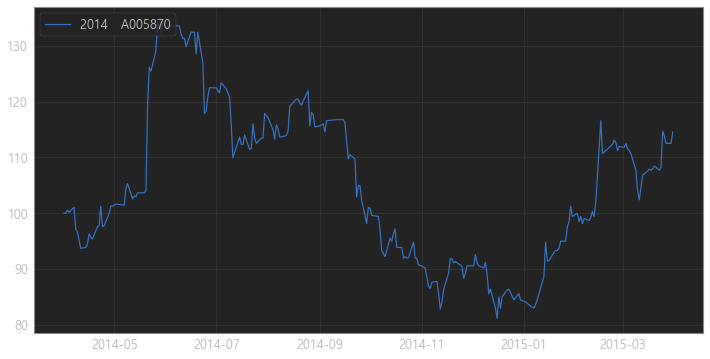

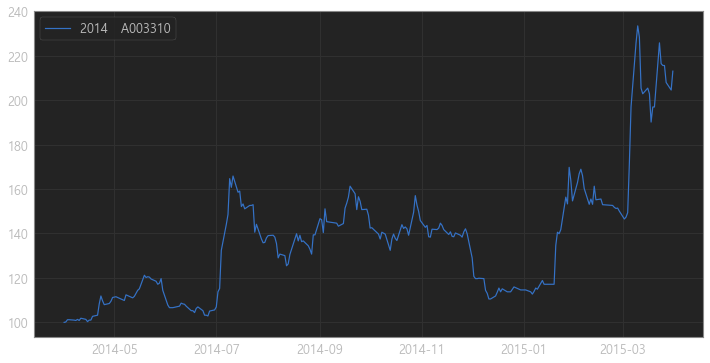

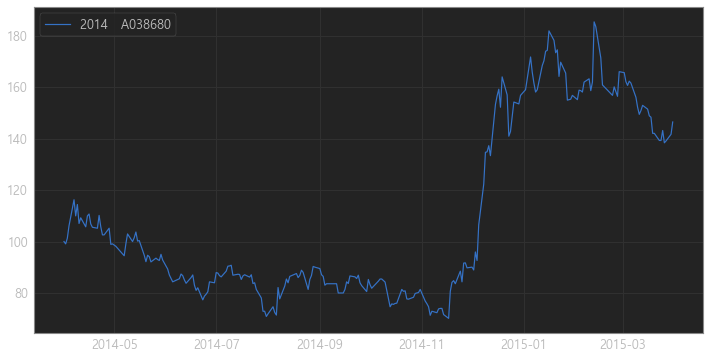

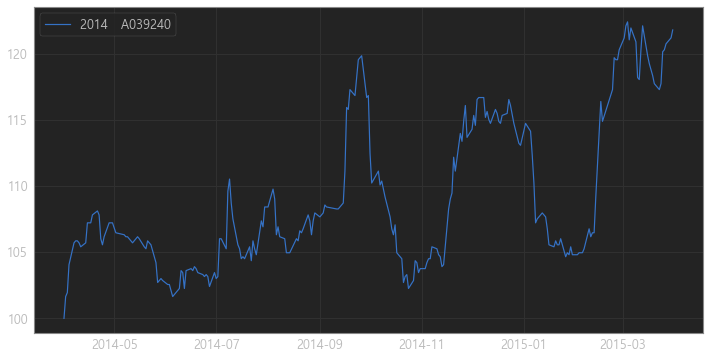

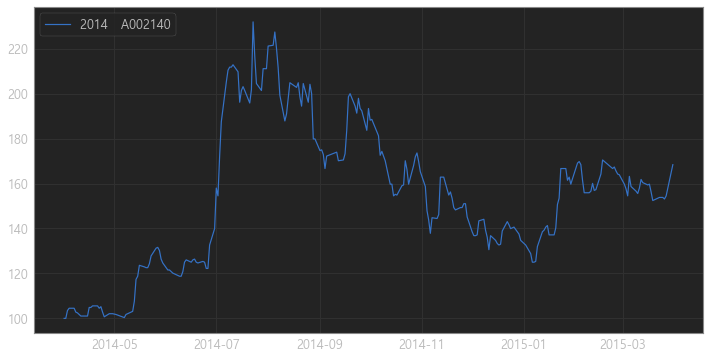

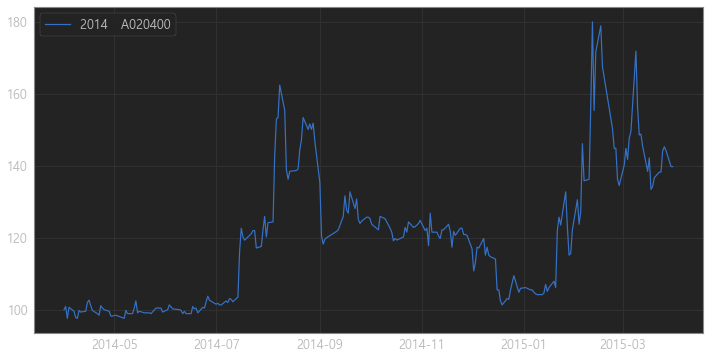

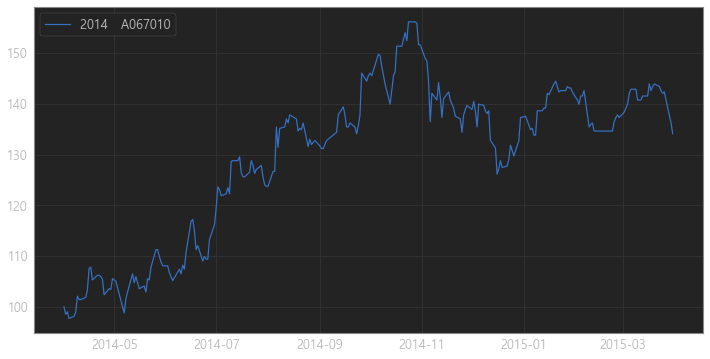

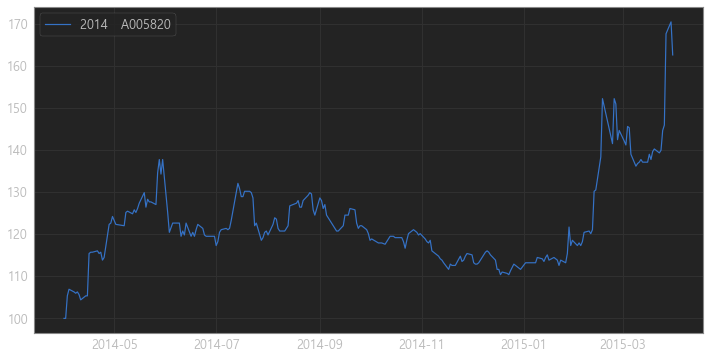

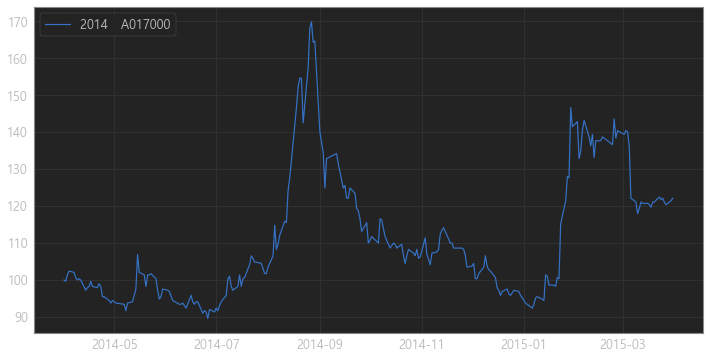

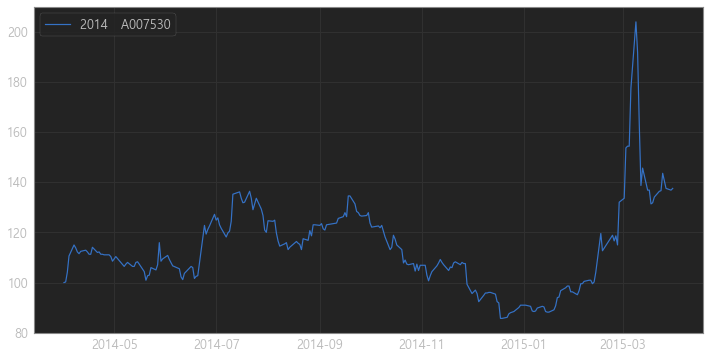

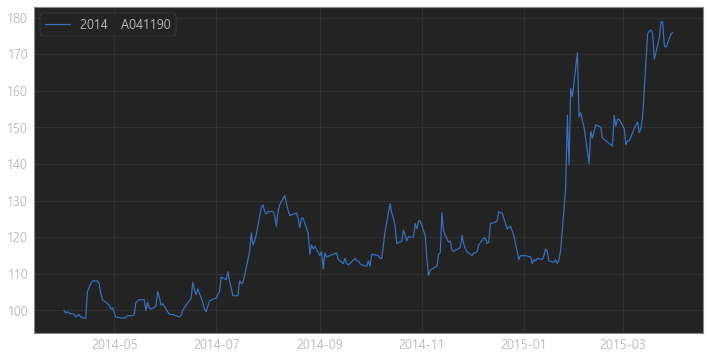

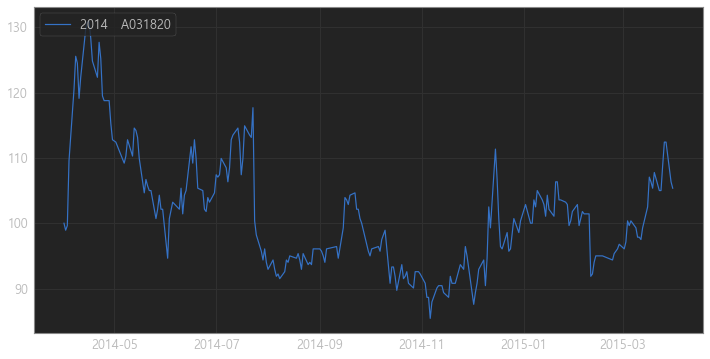

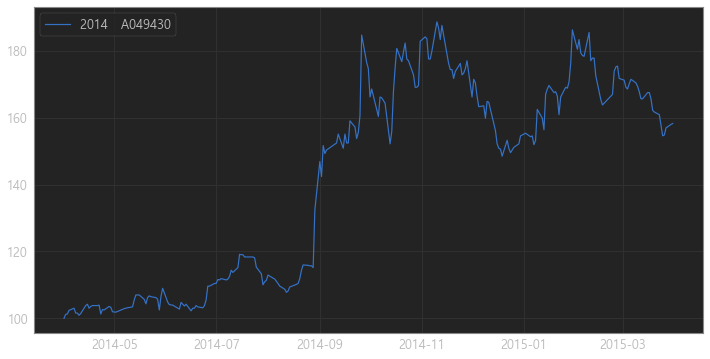

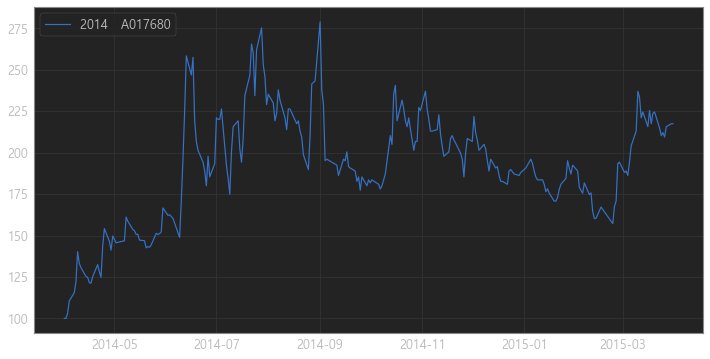

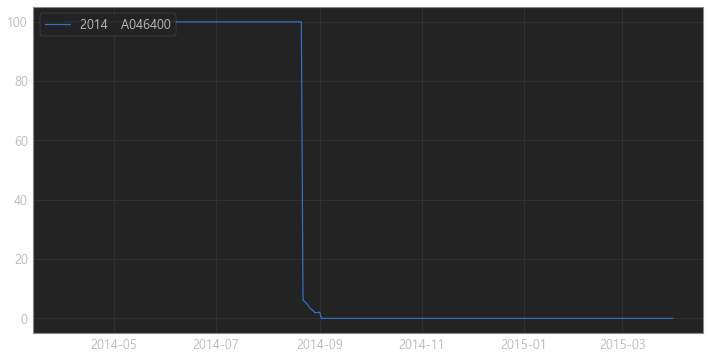

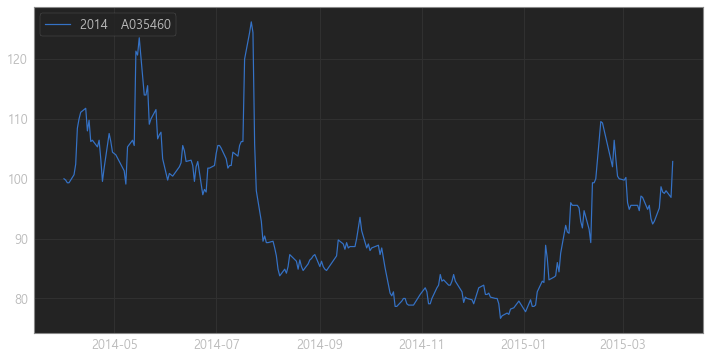

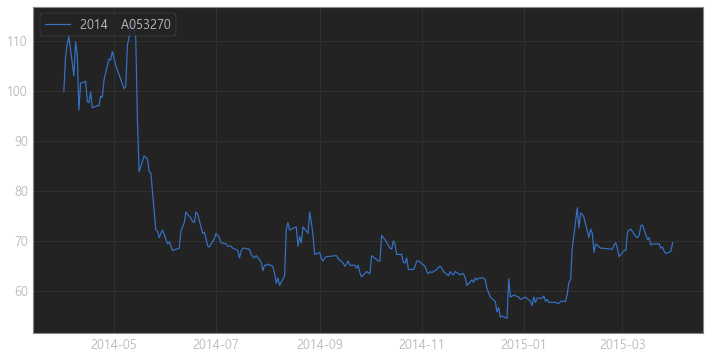

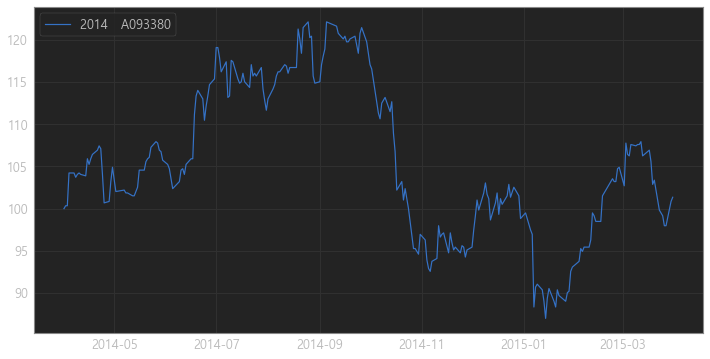

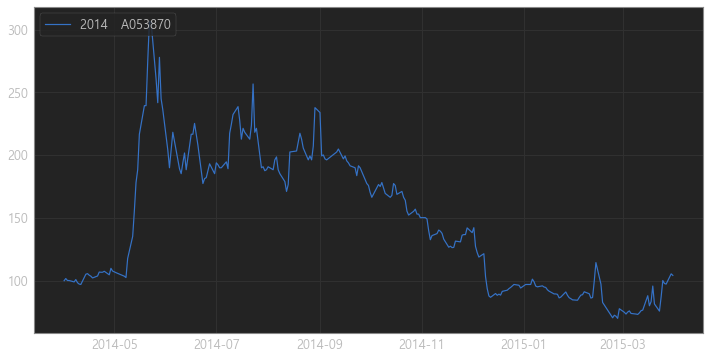

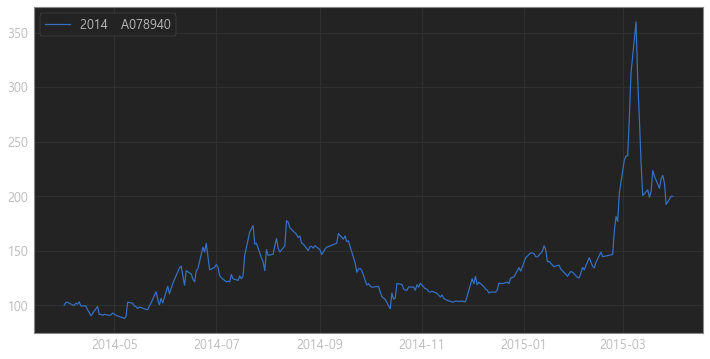

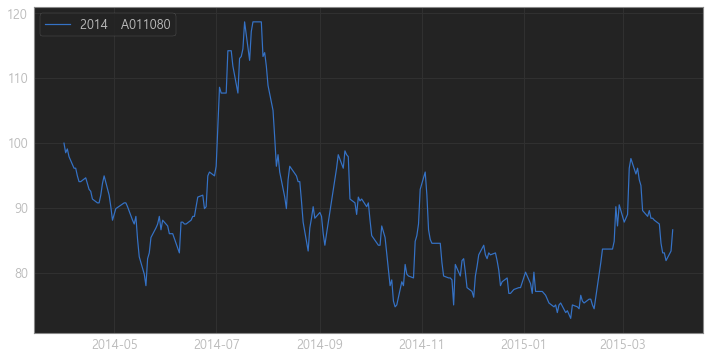

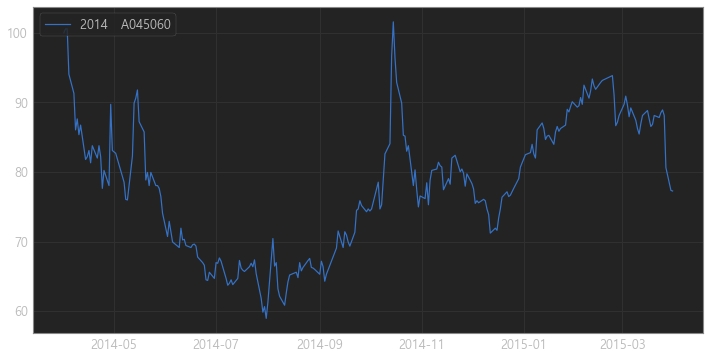

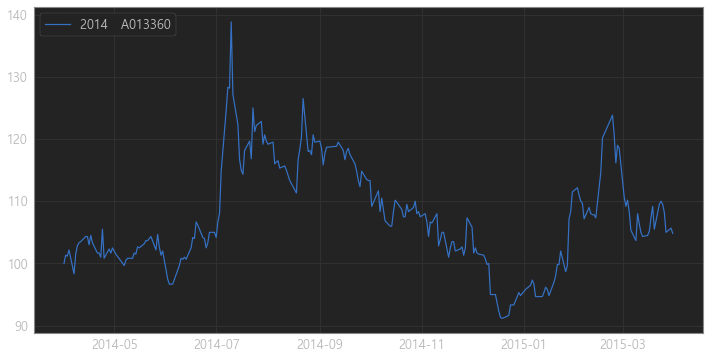

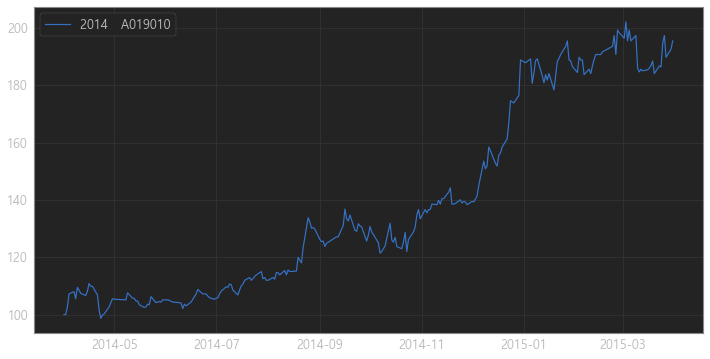

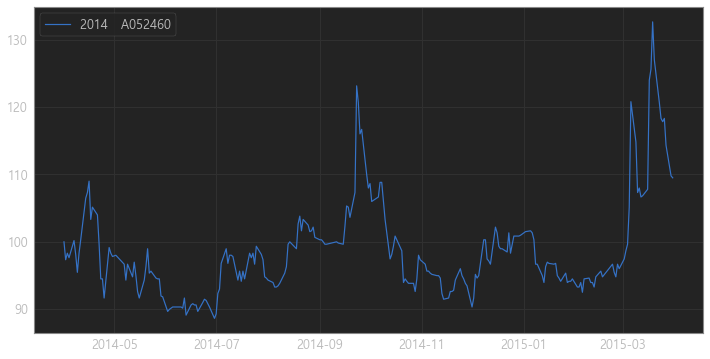

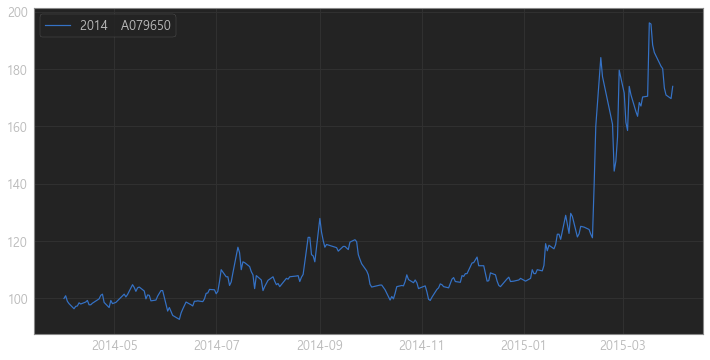

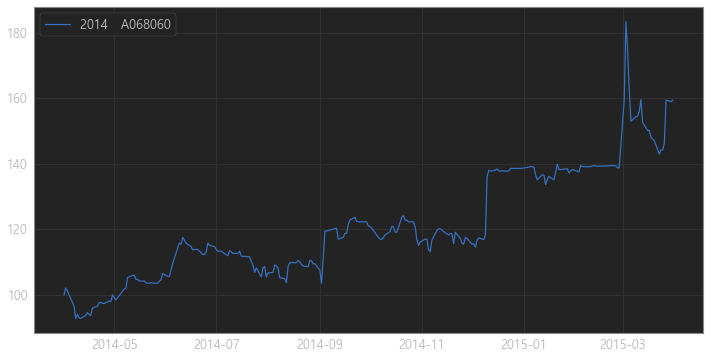

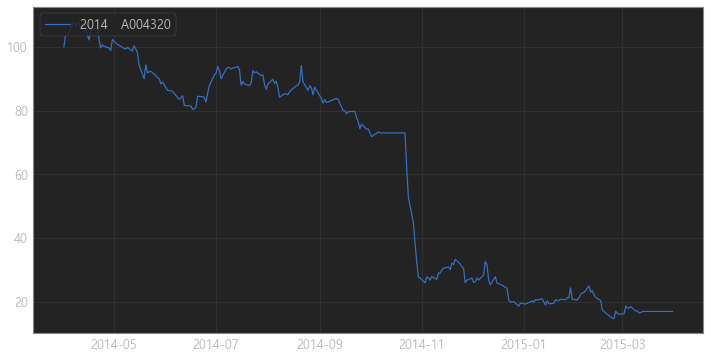

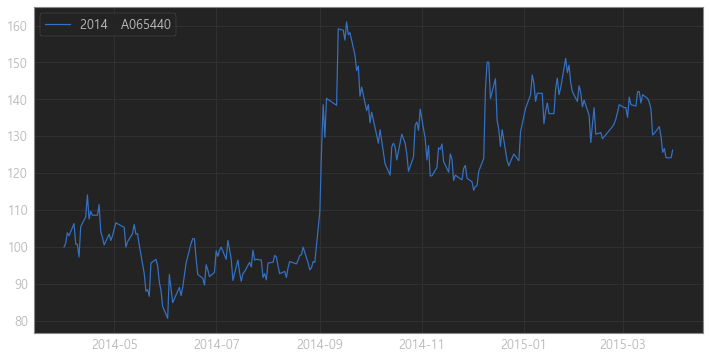

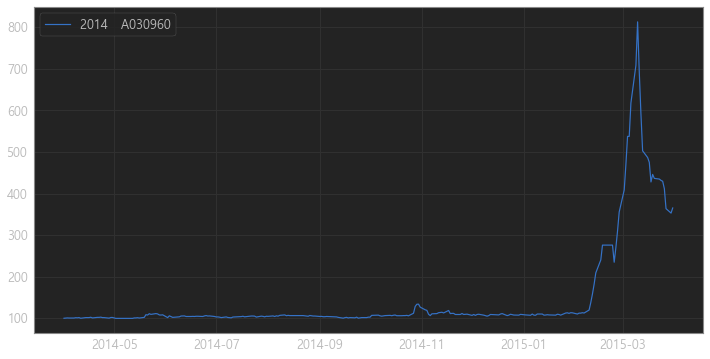

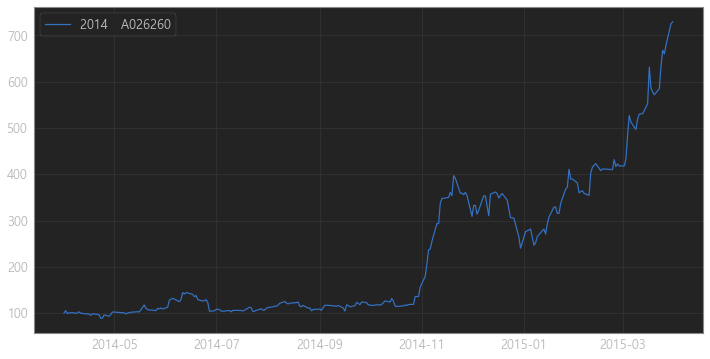

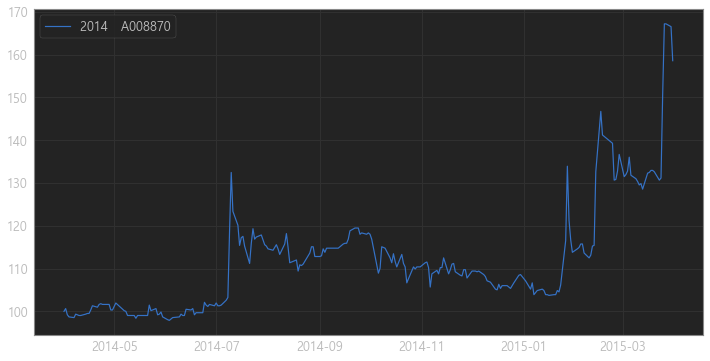

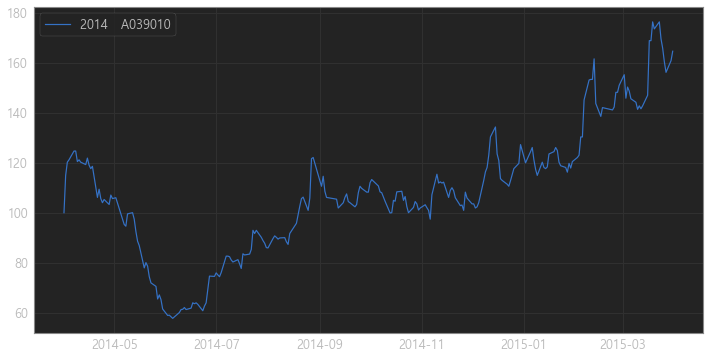

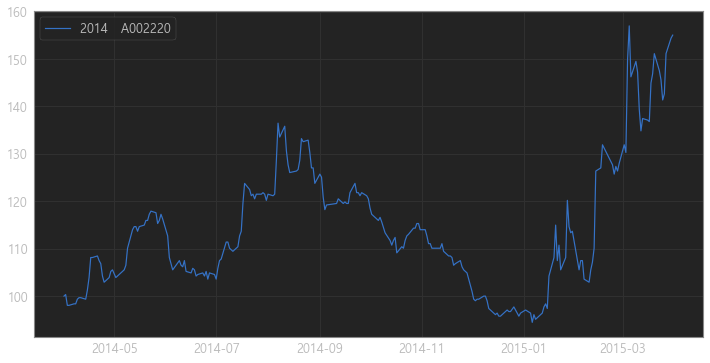

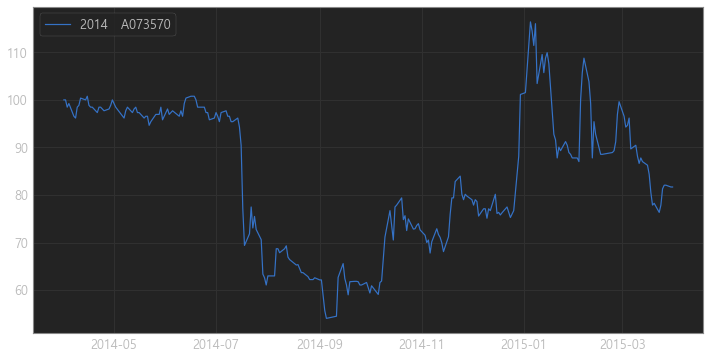

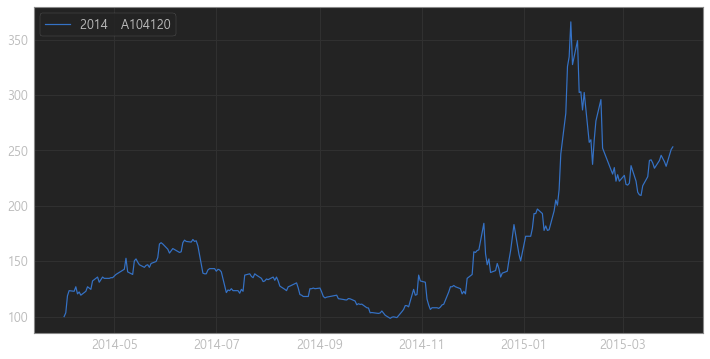

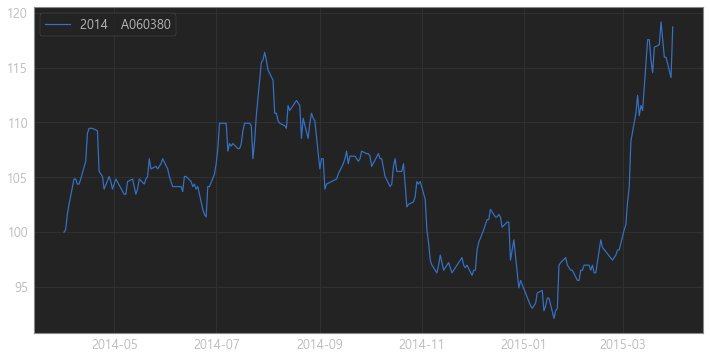

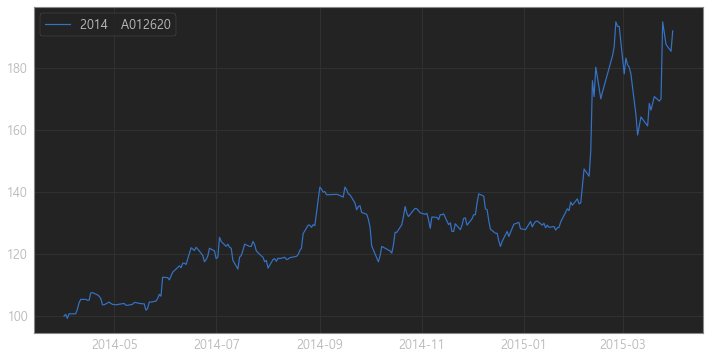

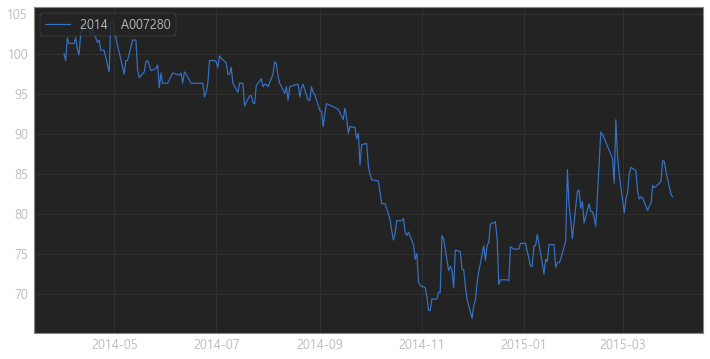

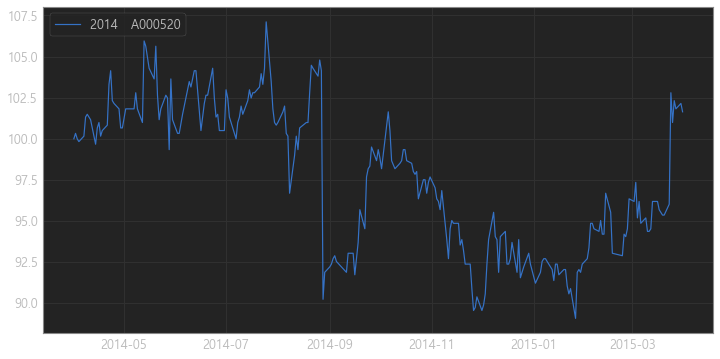

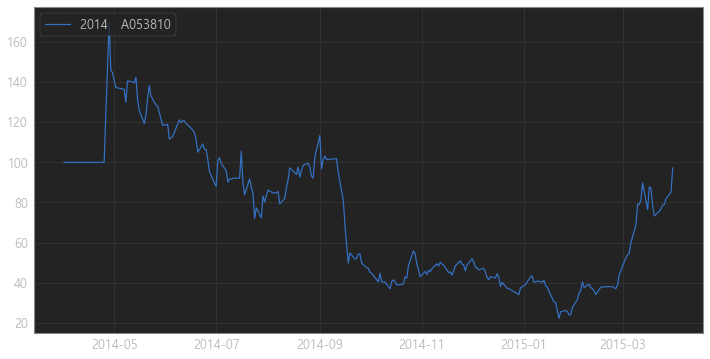

In [32]:
performance.get_individual_ts_scaled_val(ts_price_years, buy_list)